In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tellurium as te
from roadrunner import Config
import pandas as pd
import test_dict

plt.style.use('seaborn-darkgrid')
'''
from matplotlib import rc,rcParams

SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 19

rc('font', weight='bold')
rcParams['axes.labelsize'] = BIGGER_SIZE
rcParams['xtick.labelsize'] = MEDIUM_SIZE
rcParams['ytick.labelsize'] = MEDIUM_SIZE
rcParams['legend.fontsize'] = MEDIUM_SIZE
rcParams['text.usetex'] = False
'''

"\nfrom matplotlib import rc,rcParams\n\nSMALL_SIZE = 10\nMEDIUM_SIZE = 15\nBIGGER_SIZE = 19\n\nrc('font', weight='bold')\nrcParams['axes.labelsize'] = BIGGER_SIZE\nrcParams['xtick.labelsize'] = MEDIUM_SIZE\nrcParams['ytick.labelsize'] = MEDIUM_SIZE\nrcParams['legend.fontsize'] = MEDIUM_SIZE\nrcParams['text.usetex'] = False\n"

In [2]:
def plot_wth_parameters(model, parameters:dict, name:str):
    
    model.resetToOrigin()
    
    model = set_model_parameters(model, parameters)
    try:
        model.steadyState()
    except RuntimeError:
        print(esti)
        return None
    
    res = model.simulate()
    
    simu_p = simulation_to_panda(model, res[-1::])
    simu_d = simu_p[-1::].to_dict('list')
    sqd_sum, names = compute_sqd_distance(simu_d, scatter_dic)
    sqd_d = dict(zip(names, sqd_sum))
    
    fig = plt.figure(figsize=(15,24))
    rows = 6
    ncol= 3
    nx, ny = (rows, ncol)
    x = np.linspace(0, rows-1, nx)
    y = np.linspace(0, ncol-1, ny)

    xv, yv = np.meshgrid(x, y)
    coor_list = np.column_stack((xv.ravel(),yv.ravel()))
    coor_list = [x for x in coor_list if x[0] != 0]

    ax1 = plt.subplot2grid((rows, ncol), (0, 0), colspan=3)
    ax1.set_title(name + " {:.2e}".format(sqd_sum.sum()))
    for it, col in enumerate(simu_p.columns):

        cor=(int(coor_list[it][0]),int(coor_list[it][1]))
        color = 'tab:blue'
        ax2 = plt.subplot2grid((rows, ncol), cor)
        ax2.scatter(x=[129600/3600], y=simu_p[col])
        ax2.set_title(col)
        
        if col in scatter_dic:
            num = "{:.3e}".format(sqd_d[col])
            ax2.set_title(num + col)
            scatter_amount = np.asarray(scatter_dic[col]['values']) 
            scatter_std = np.asarray(scatter_dic[col]['std'])

            ax2.errorbar(x=[129600/3600]*len(scatter_amount[0]), y=scatter_amount[0],
                         xerr=0, fmt='o', color='red', yerr=scatter_std[0])
            

def set_model_parameters(model, params, excluded_values=[]):
    no_names = excluded_values
    for param_id in params: 
        if any(x in param_id for x in no_names):
            continue
        else:
            try:
                model[param_id] = params[param_id]
                # print(model[param_id])
            except KeyError:
                print('could not set parameter : {0}'.format(param_id))
                continue
            except TypeError:
                #print('try to set {0} to {1}'.format(model[param_id]),params[param_id])
                print(format(model[param_id]))  # 
                print(format(params[param_id]))
    return model

In [3]:
def compute_sqd_distance(simulation_result_dict, data, factor=10**1,
                         normalized=True):

    # list of intersecting keys, as only those relevant
    inter = simulation_result_dict.keys() & data.keys()

    dist_ar = np.zeros(len(inter))

    alex_bias_lst = ['DAG', 'Phosphatidylserine_mem',
                     'Phosphatidylethanolamine_mem', 'Phosphatidylcholine_mem']

    for ar_pos, molecule in enumerate(inter):
        if molecule == 'time':
            continue
        dist = 0.

        bias_fac = 1
        if molecule in alex_bias_lst:
            bias_fac = 2
        # iterate through the measured timepoints, thus finer evaluation of fit
        for i, values in enumerate(data[molecule]['values']):
            for pos, value in enumerate(values):
                # data entries empty as no literature value found, thus skipped
                if np.isnan(value):
                    continue
                if normalized:
                    dist += np.nansum(((value
                            - simulation_result_dict[molecule][i])**2  # noqa: E128
                            * bias_fac)  # noqa:E128
                            / data[molecule]['std'][i][pos]**2)   # noqa: E128

                else:
                    dist += np.nansum(bias_fac*(value
                            - simulation_result_dict[molecule][i])**2)  # noqa:E128
        dist_ar[ar_pos] = dist * factor

    return dist_ar, inter

In [4]:
def calc_scores(simulation_nums, molecule, data, normalized=True, factor=1e1):

    scores = np.zeros(len(simulation_nums))
    alex_bias_lst = ['DAG', 'Phosphatidylserine_mem',
                     'Phosphatidylethanolamine_mem', 'Phosphatidylcholine_mem']

    if molecule == 'time':
        return None
    for ar_pos, simulation_num in enumerate(simulation_nums):
        dist = 0.

        bias_fac = 1
        if molecule in alex_bias_lst:
            bias_fac = 2
        # iterate through the measured timepoints, thus finer evaluation of fit
        for i, values in enumerate(data[molecule]['values']):
            for pos, value in enumerate(values):
                # data entries empty as no literature value found, thus skipped
                if np.isnan(value):
                    continue
                if normalized:
                    dist += np.nansum(((value
                            - simulation_num)**2  # noqa: E128
                            * bias_fac)  # noqa:E128
                            / data[molecule]['std'][i][pos]**2)   # noqa: E128

                else:
                    dist += np.nansum(bias_fac*(value
                            - simulation_result_dict[molecule][i])**2)  # noqa:E128
        scores[ar_pos] = dist * factor
    return scores

In [5]:
def simulation_to_panda(model, simulation_result, col=['time']):
    return pd.DataFrame(simulation_result, columns=col
                        + model.getFloatingSpeciesIds())


In [6]:
def get_best_scoring_parameter_set(d_path):
    '''
    Description: function to find the best scoring parameter set for specified model
    -----------
    Parameter:
    d_path: pathway to directory with parameter sets
    ----------
    returns:
    dresults: pd.DataFrame() with best score as name and parameter names as index
    '''
    files = os.listdir(d_path)
    files = [file for file in files if file.endswith('paras.txt')]
    
    dresults = pd.DataFrame()
    for file in files:
        filename = file
        path = datapath
        with open(path+filename, 'rb') as g:
            data = pickle.loads(g.read())
        #data[1]['score']=data[0]
        dnew = pd.DataFrame.from_dict(data[1], orient='index',columns=['Value'])
        dresults[str(data[0])] = dnew['Value']
    results = sorted(list(map(float, dresults.columns.to_list())))
    
    return dresults[str(results[0])]

In [7]:
options = {1: "cPL_conc",
           2: "noV_cPL_conc",
           3: "pc_pe_PL",
           4: "PLModel",
           5: "SS_PLModel_ConKin",
           6: "SS_PLModel_E_MA",
           7: "SS_PLModel_MA",
           8: "SS_PLModel_MM"
           }
name = options[8]
modelpath = "model_files/" + name + ".atm"
datapath = "CMA_files/"+name+"/"
Alex_to_amount = 1e-18*6.02214086e23
Alex_to_amount=1

In [8]:
# get best parameter set for each model
best_para_models = {}
for _ in range(5,9):
    name = options[_]
    if not 'E_MA' in name:
        datapath = "CMA_files/"+name+"/"
        best_para_models[name] = get_best_scoring_parameter_set(datapath)

In [9]:
tup = list(best_para_models)
name = tup[2]
# set correct pathway for model
print(name)
datapath = "CMA_files/"+name+"/"
modelpath = "model_files/" + name + ".atm"
# load model
model = te.loada(modelpath)

SS_PLModel_MM


In [10]:
# set model to estimation parameters
model = set_model_parameters(model, best_para_models[name].to_dict())

In [11]:
# Make test dictionary
scatter_dic = test_dict.mke_test_dict(model, timepoints=['troph'])

In [12]:
# simulate model
r = model.simulate()
# get pandas dataframe of model results
d = simulation_to_panda(model, r)

In [13]:
model.conservedMoietyAnalysis = True
# calculate steady state of models species concentrtion, approximates if need be
model.steadyState()
# get pandas dataframe of the steady state species than make dictionary of it
simulation_to_panda(model, model.getSteadyStateValuesNamedArray(), [])[-1::].to_dict('list')

{'Phosphatidylserine': [9.3015524496526e-11],
 'Ethanolamine': [314.69391967635096],
 'Choline_phosphate': [11567.80025800412],
 'Phosphatidylethanolamine': [1746.3856698515797],
 'Ethanolamine_phosphate': [10075.18080225278],
 'L_Serine': [975.8213721848717],
 'Phosphatidylcholine': [1604.441355173976],
 'Phosphatidylethanolamine_mem': [13835.913600003318],
 'Choline': [1900.8258401352798],
 'Phosphatidylserine_mem': [4363.836905708159],
 'Phosphatidylcholine_mem': [28577.7361760003],
 'CDP_ethanolamine': [1200.3147474731784],
 'CDP_choline': [752.528940827498]}

In [14]:
# get pandas dataframe of the steady state species 
simu_p = simulation_to_panda(model, model.getSteadyStateValuesNamedArray(), col=[])
# make dictionary of it, only last point of interest
simu_d = simu_p[-1::].to_dict('list')
# compute square root distance of simulation and test data
sqd_sum, names = compute_sqd_distance(simu_d, scatter_dic)
# make dict(species, square root distance value)
sqd_d = dict(zip(names, sqd_sum))

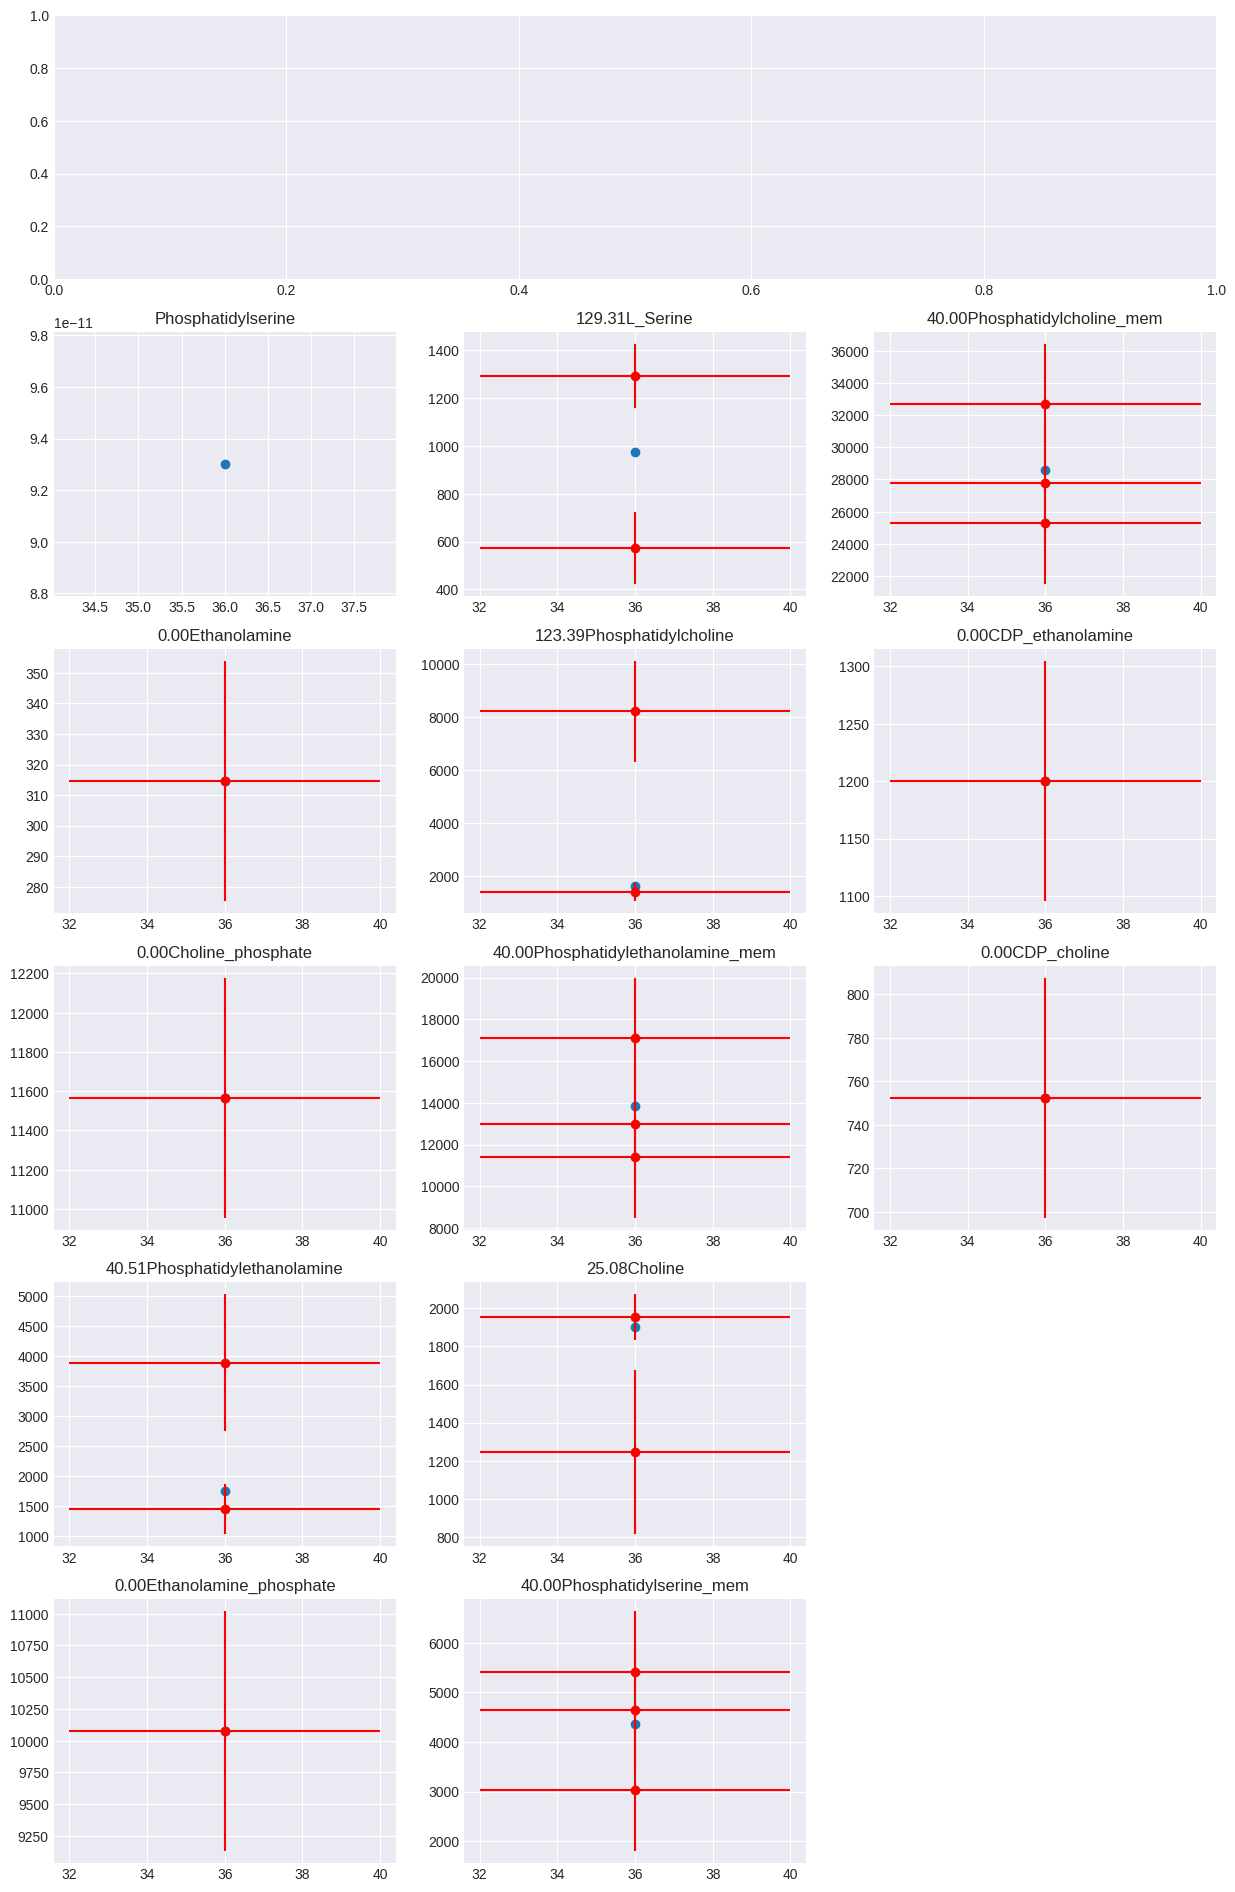

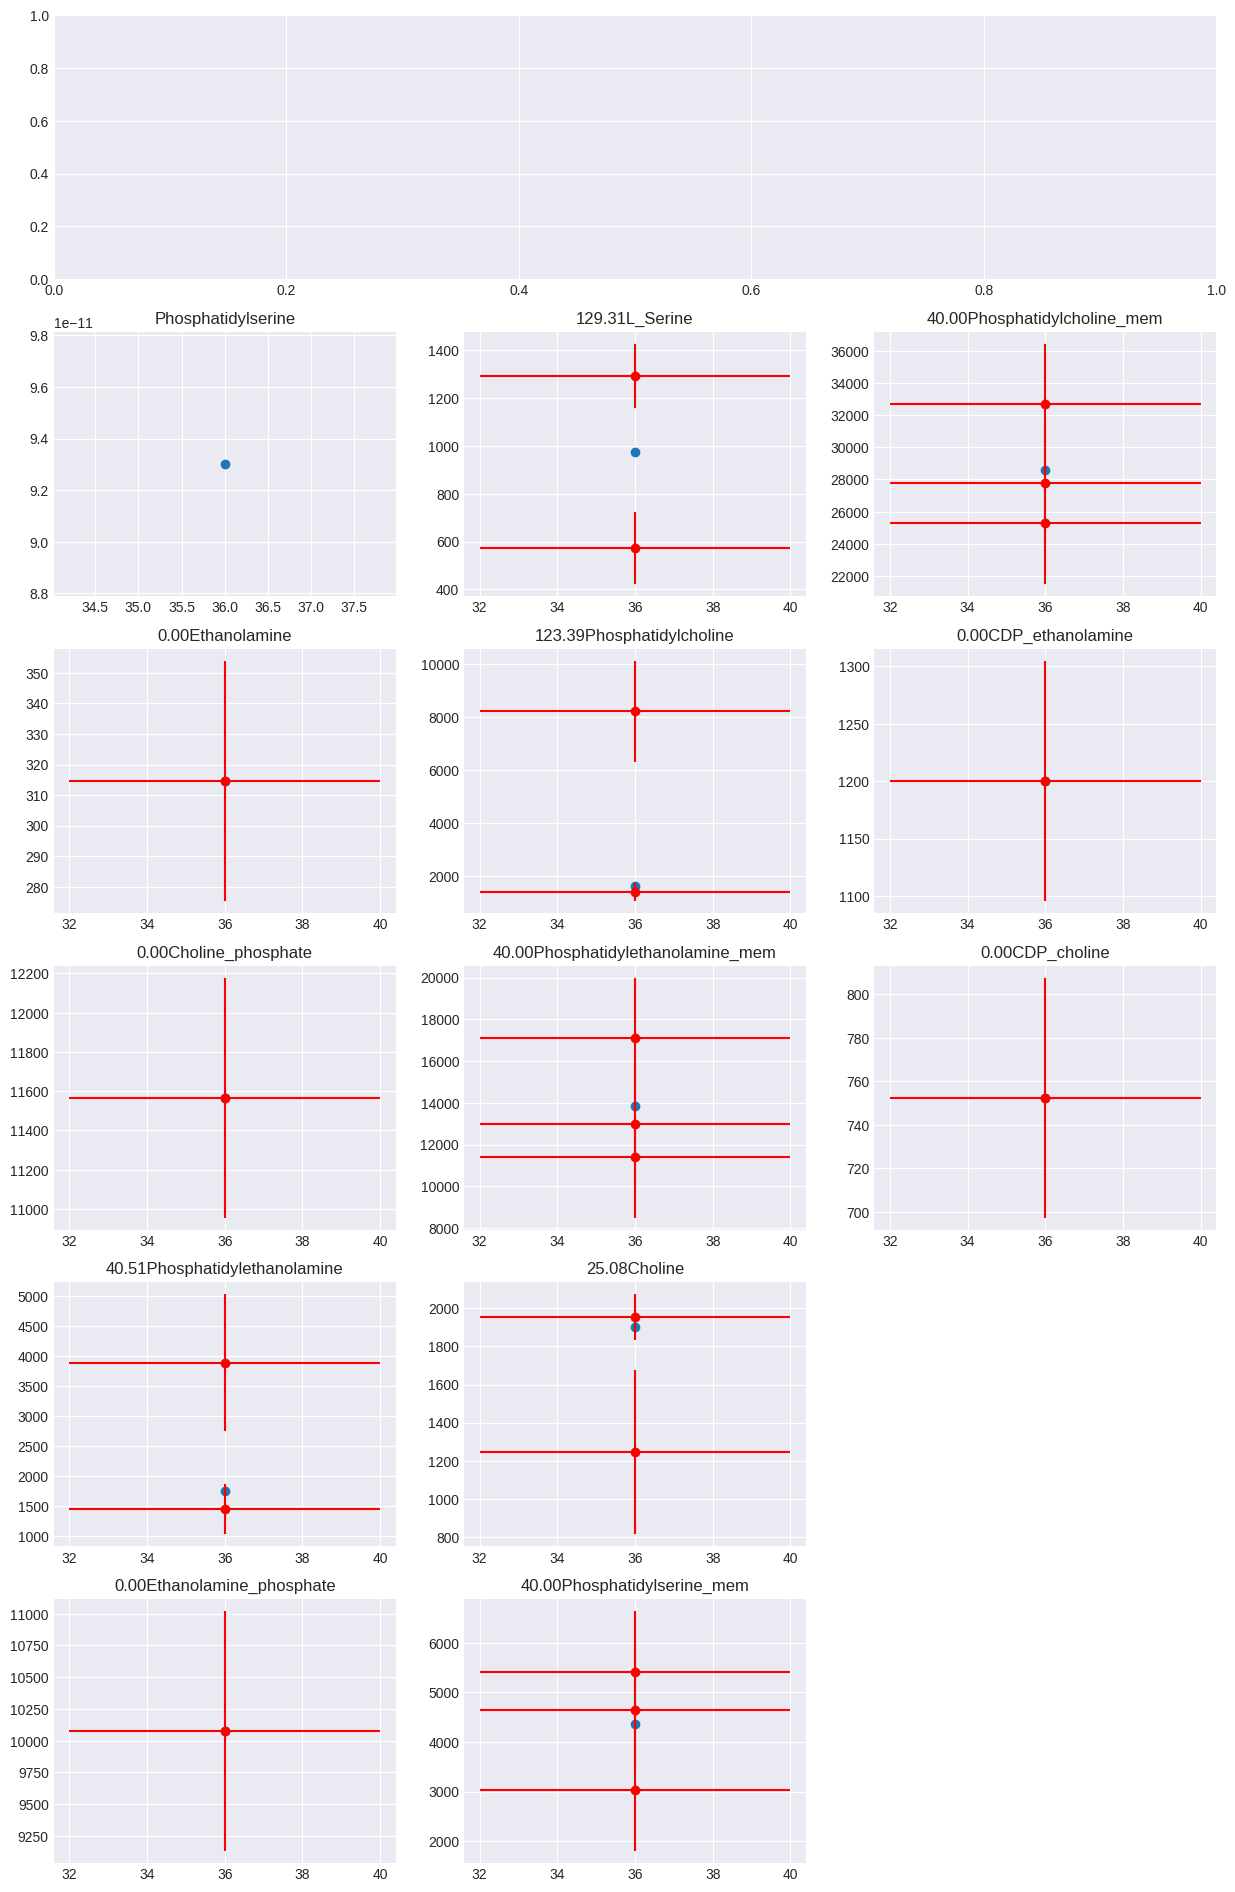

In [16]:
fig = plt.figure(figsize=(15,24))
rows = 6
ncol= 3
nx, ny = (rows, ncol)
x = np.linspace(0, rows-1, nx)
y = np.linspace(0, ncol-1, ny)

xv, yv = np.meshgrid(x, y)
coor_list = np.column_stack((xv.ravel(),yv.ravel()))
coor_list = [x for x in coor_list if x[0] != 0]
    
ax1 = plt.subplot2grid((rows, ncol), (0, 0), colspan=3)
for it, col in enumerate(simu_p.columns):
    
    cor=(int(coor_list[it][0]),int(coor_list[it][1]))
    color = 'tab:blue'
    ax2 = plt.subplot2grid((rows, ncol), cor)
    ax2.scatter(x=[129600/3600], y=simu_p[col])
    ax2.set_title(col)
    if col in scatter_dic:
        num = "{:.2f}".format(sqd_d[col])
        ax2.set_title(num+ col)
        scatter_amount = np.asarray(scatter_dic[col]['values']) 
        scatter_std = np.asarray(scatter_dic[col]['std'])

        ax2.errorbar(x=[129600/3600]*len(scatter_amount[0]), y=scatter_amount[0],
                     xerr=4, fmt='o', color='red', yerr=scatter_std[0]
                    )
plt.show()

In [17]:
files = os.listdir(datapath)
files = [file for file in files if file.endswith('paras.txt')]
#files = [file for file in files if file.startswith('2020')]
files= sorted(files)
files

['20210831-13:06:481whole_paras.txt',
 '20210916-10:22:361whole_paras.txt',
 '20210927-15:18:391whole_paras.txt',
 '20210928-13:57:531whole_paras.txt',
 '20210928-14:13:581whole_paras.txt',
 '20210928-15:42:231whole_paras.txt',
 '20210929-16:34:311whole_paras.txt',
 '20210929-16:37:061whole_paras.txt',
 '20210929-16:38:141whole_paras.txt',
 '20210929-16:38:221whole_paras.txt',
 '20210929-16:45:121whole_paras.txt',
 '20220110-15:35:101whole_paras.txt']

In [18]:
df = pd.DataFrame()
for file in files:
    filename = file
    path = datapath
    print(path + filename)
    with open(path+filename, 'rb') as g:
        data = pickle.loads(g.read())
    dnew = pd.DataFrame.from_dict(data[1], orient='index',columns=['Value'])
    #print(file)
    #print(np.log10(dnew['Value']))
    df[str(data[0])] = dnew['Value']

CMA_files/SS_PLModel_MM/20210831-13:06:481whole_paras.txt
CMA_files/SS_PLModel_MM/20210916-10:22:361whole_paras.txt
CMA_files/SS_PLModel_MM/20210927-15:18:391whole_paras.txt
CMA_files/SS_PLModel_MM/20210928-13:57:531whole_paras.txt
CMA_files/SS_PLModel_MM/20210928-14:13:581whole_paras.txt
CMA_files/SS_PLModel_MM/20210928-15:42:231whole_paras.txt
CMA_files/SS_PLModel_MM/20210929-16:34:311whole_paras.txt
CMA_files/SS_PLModel_MM/20210929-16:37:061whole_paras.txt
CMA_files/SS_PLModel_MM/20210929-16:38:141whole_paras.txt
CMA_files/SS_PLModel_MM/20210929-16:38:221whole_paras.txt
CMA_files/SS_PLModel_MM/20210929-16:45:121whole_paras.txt
CMA_files/SS_PLModel_MM/20220110-15:35:101whole_paras.txt


In [139]:
len(df.index.tolist())

57

In [19]:
df

,13129.507299032326,2782.9747433090024,1630.652849158281,2.832746129256407e+25,7.58373571221286e+23,4298.063974157399,1e+30,438.28680422216735,438.2868042221673,438.28680422216723
vmax_R02055,2.284656e-03,1.097695e+00,1.116252e+04,1.521853e-05,9.099610e-01,4.144064e-05,4.497621e-03,5.421176e-04,3.388351e-01,1.721549e-01
km_Phosphatidylserine_R02055,2.103820e+05,6.885650e+04,1.926583e+05,2.122292e+05,1.182217e+05,1.080947e+05,2.646046e+05,2.076327e+05,1.147536e+05,1.263121e+05
vmax_R02037,1.124894e+04,5.476501e-01,4.363285e-04,6.949243e+00,5.612889e-01,2.082482e-02,7.964362e-04,1.285761e-03,7.057098e+01,3.729675e-03
km_Ethanolamine_phosphate_R02037,8.886816e+05,7.950697e+05,4.745637e+05,2.444341e+05,3.315542e+05,7.226333e+05,9.822087e+05,3.631049e+05,4.536719e+05,5.020599e+05
vmax_EtOHamine_in,3.106714e-05,7.909561e-03,2.436983e-04,5.613704e-03,6.510828e+01,8.196844e-04,8.816875e+01,9.191067e-02,4.868697e-01,9.216765e-04
km_External_Ethanolamine_EtOHamine_in,1.863246e-03,2.695278e+01,1.275288e+02,7.119290e-01,1.708414e-02,3.956139e+02,2.287809e+02,1.356664e+05,1.002703e-08,5.432274e+02
vmax_L_Serine_in,6.739892e+02,1.181553e+00,1.018894e-02,4.151186e-03,8.058393e+01,1.027307e-05,1.533158e-01,1.094317e+00,1.290968e+04,6.482933e+01
km_External_L_Serine_L_Serine_in,6.107473e+05,2.856939e-01,1.905026e+04,6.786339e+03,5.376404e-07,1.329208e+01,5.259626e+07,1.785151e+05,1.550359e+03,2.209126e+07
vmax_Choline_in,2.954668e-03,1.012898e-02,2.805608e-04,1.135872e-02,1.734748e+02,1.341915e-01,2.153849e-05,7.751244e-01,3.331373e+01,1.021118e+00
km_External_Choline_Choline_in,2.084574e+03,5.301708e+03,9.866052e-02,8.927209e-05,2.830798e-02,5.311906e+06,5.116827e-04,2.389639e-06,1.287125e+02,1.804783e+05


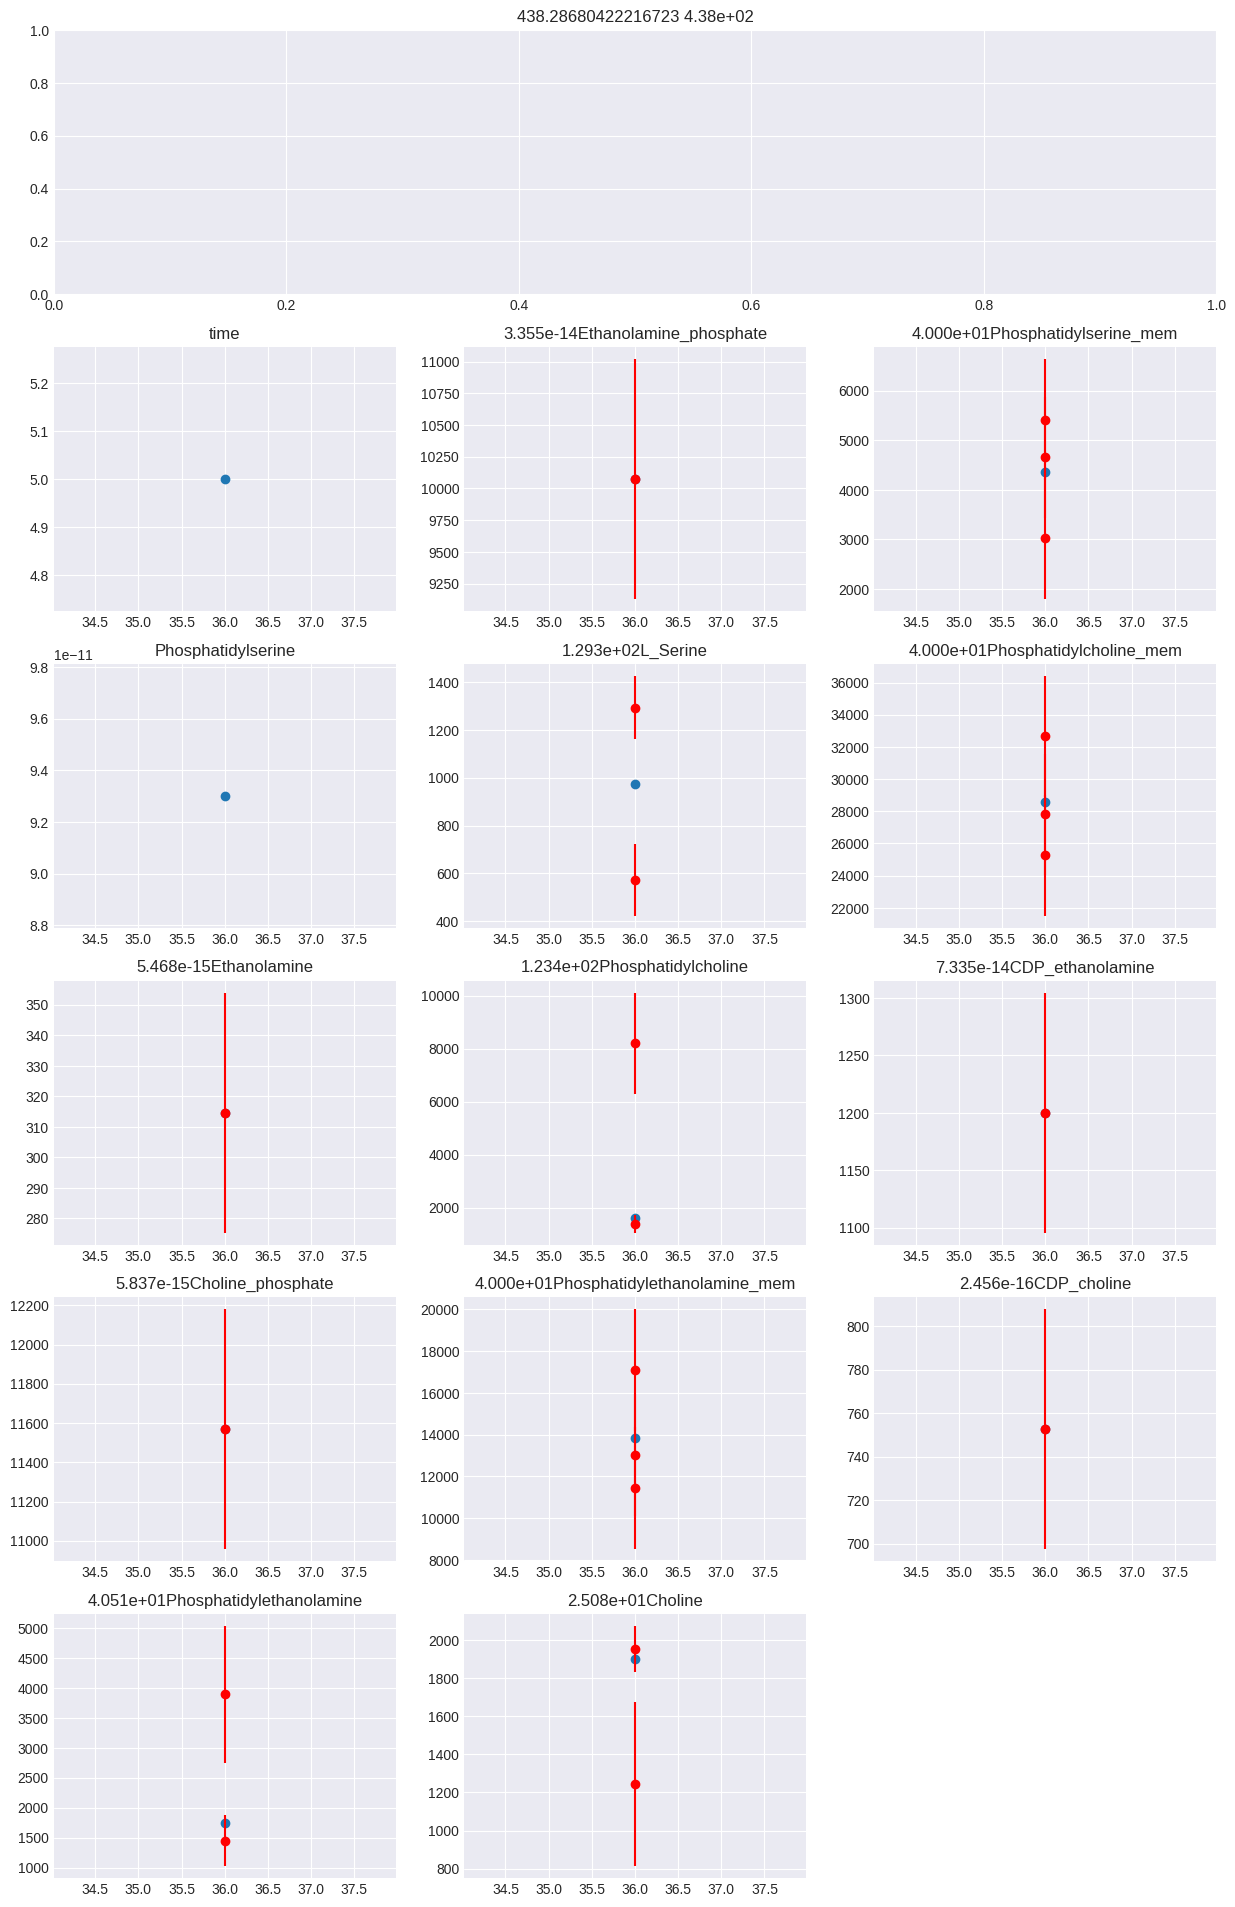

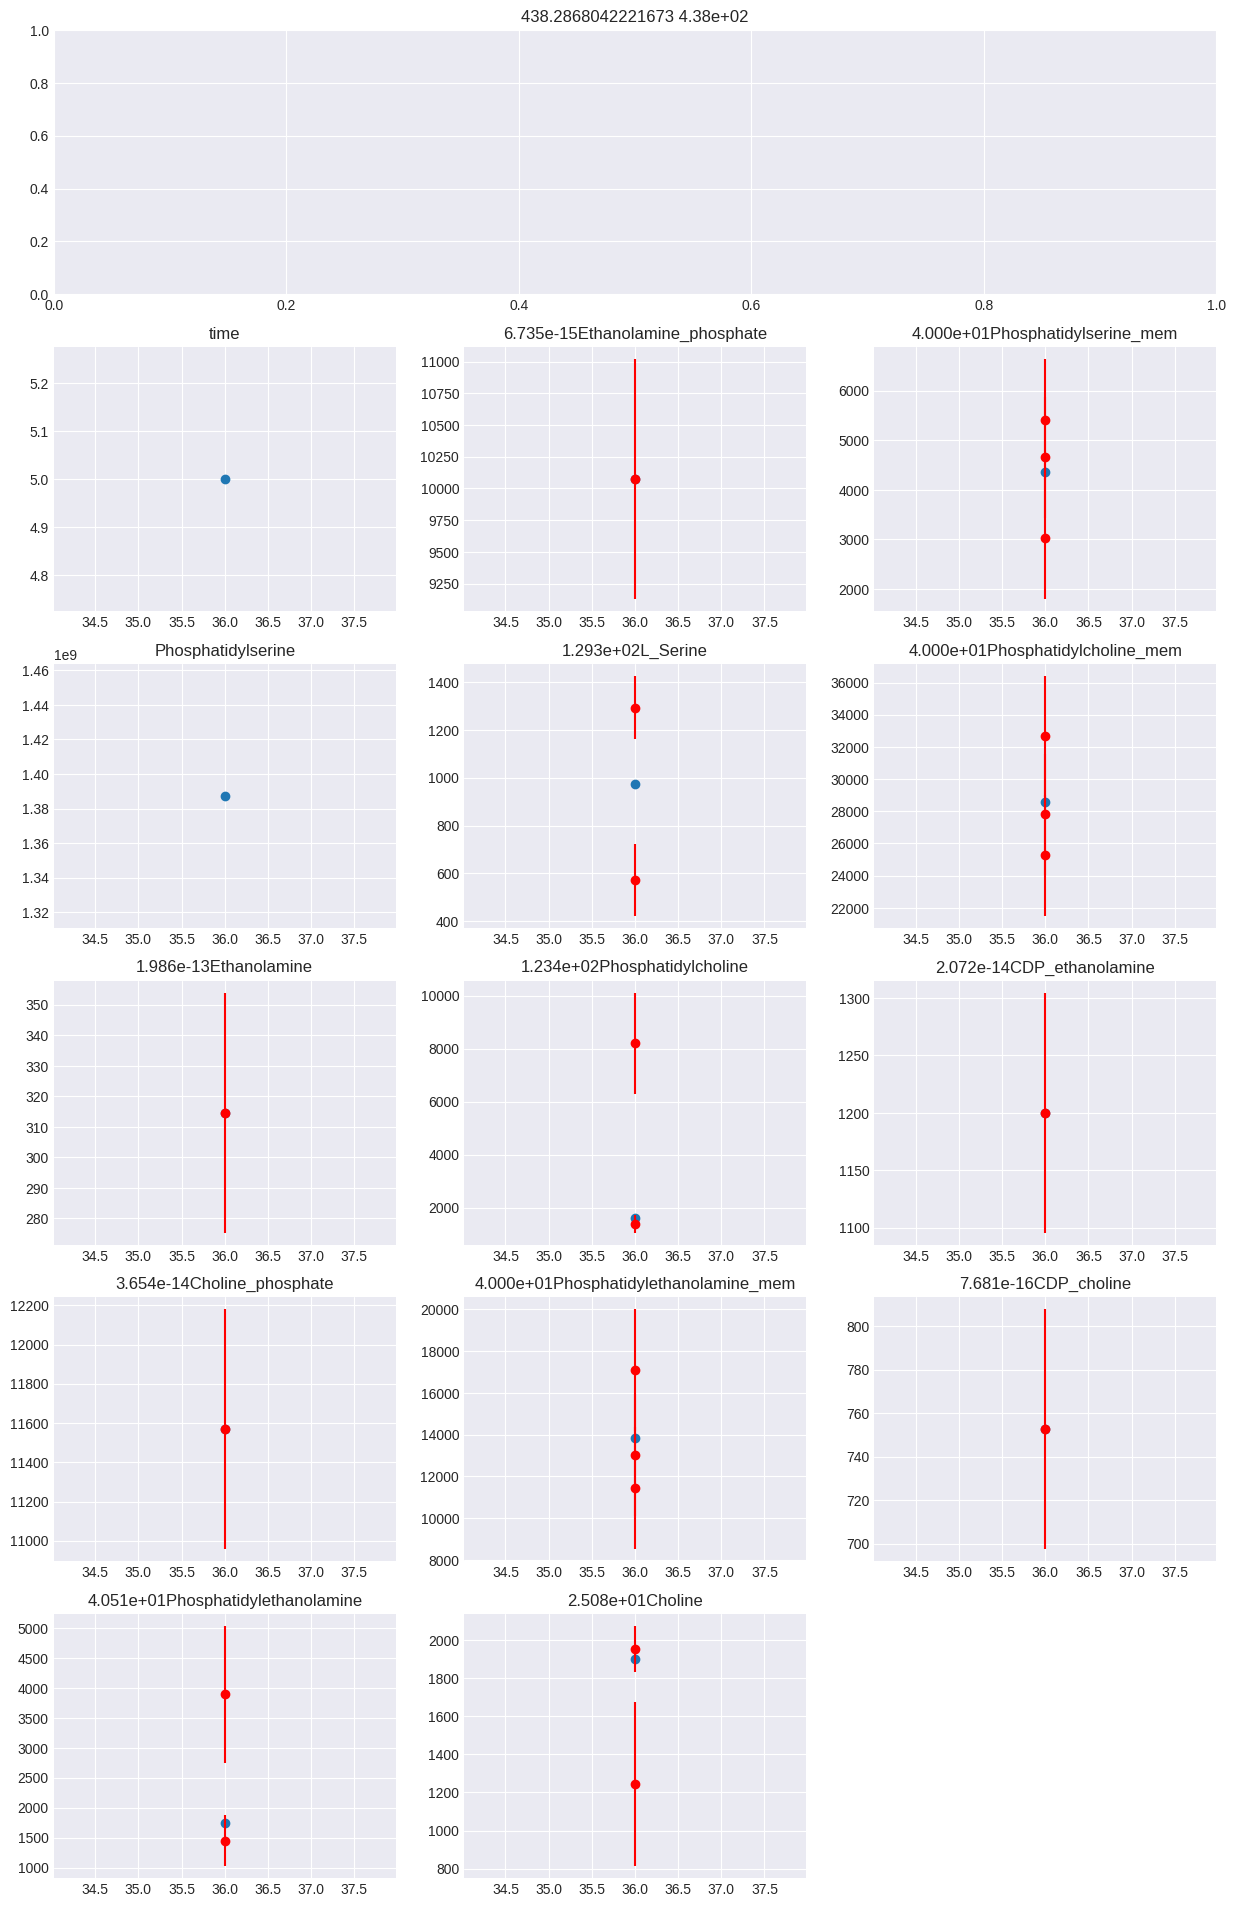

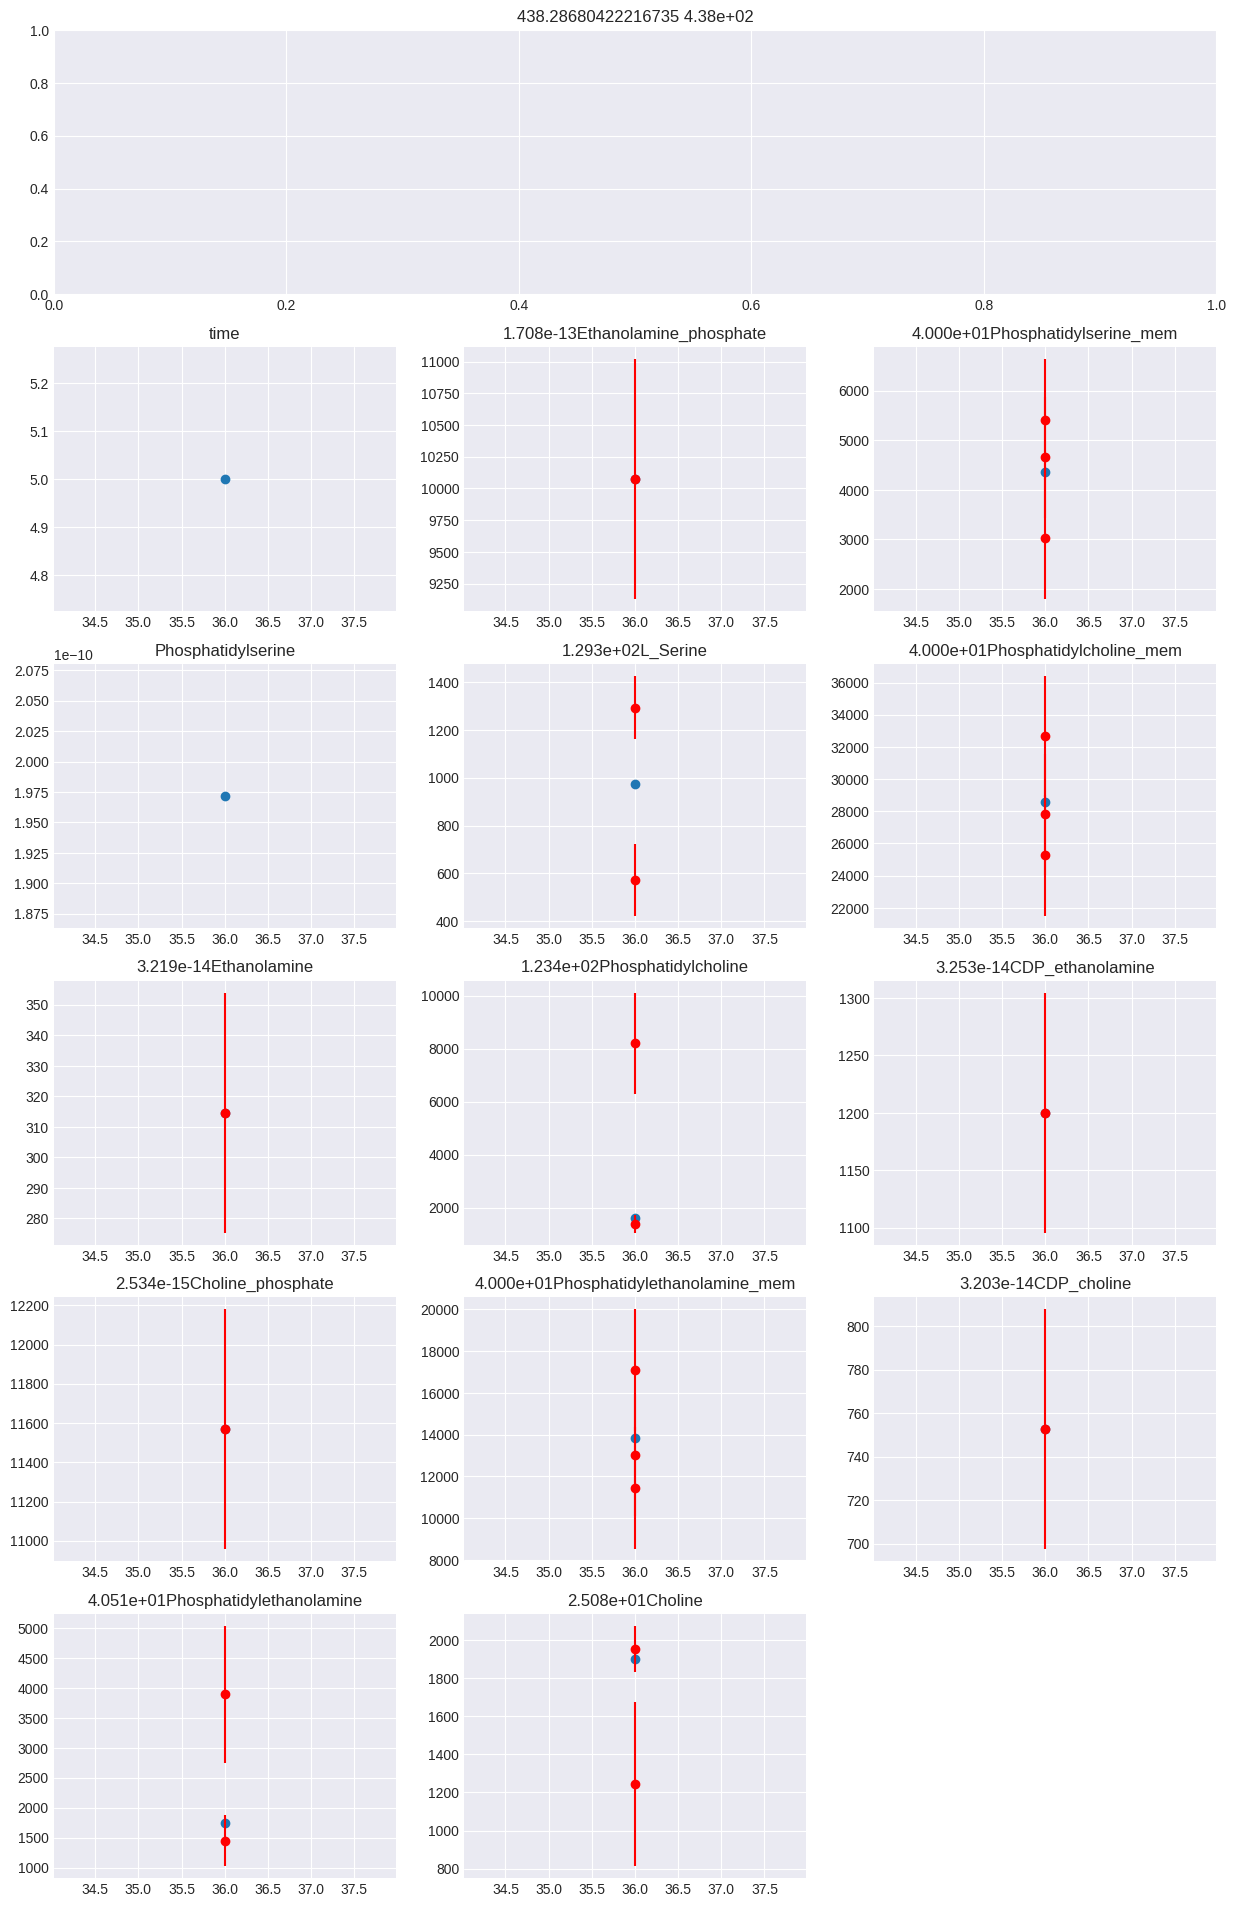

In [22]:
scores = list(map(float, df.columns.to_list()))
for esti in sorted(scores)[:3]:
    plot_wth_parameters(model, df[str(esti)].to_dict(), str(esti))
    plt.show()

In [23]:
results = list(map(float, df.columns.to_list()))
sorted(results)
print(results)
esti = results[-1]
print(esti)
model.resetToOrigin()
model = set_model_parameters(model, df[str(esti)].to_dict())
model.steadyState()
res = model.simulate()
res_p = simulation_to_panda(model, res)
#res_p


[13129.507299032326, 2782.9747433090024, 1630.652849158281, 2.832746129256407e+25, 7.58373571221286e+23, 4298.063974157399, 1e+30, 438.28680422216735, 438.2868042221673, 438.28680422216723]
438.28680422216723


In [24]:
translation_dic={
    'Phosphatidylserine' : 'PS',
    'Phosphatidylethanolamine' : 'PE',
    'Phosphatidylcholine' : 'PC',
    'Phosphatidylcholine_mem' : 'PC_mem',
    'Phosphatidylethanolamine_mem' : 'PE_mem',
    'Phosphatidylserine_mem' : 'PS_mem'
}
translation_dic['Phosphatidylserine']

'PS'

# Determine the best possible Optimization score

13
0.004073337128074339


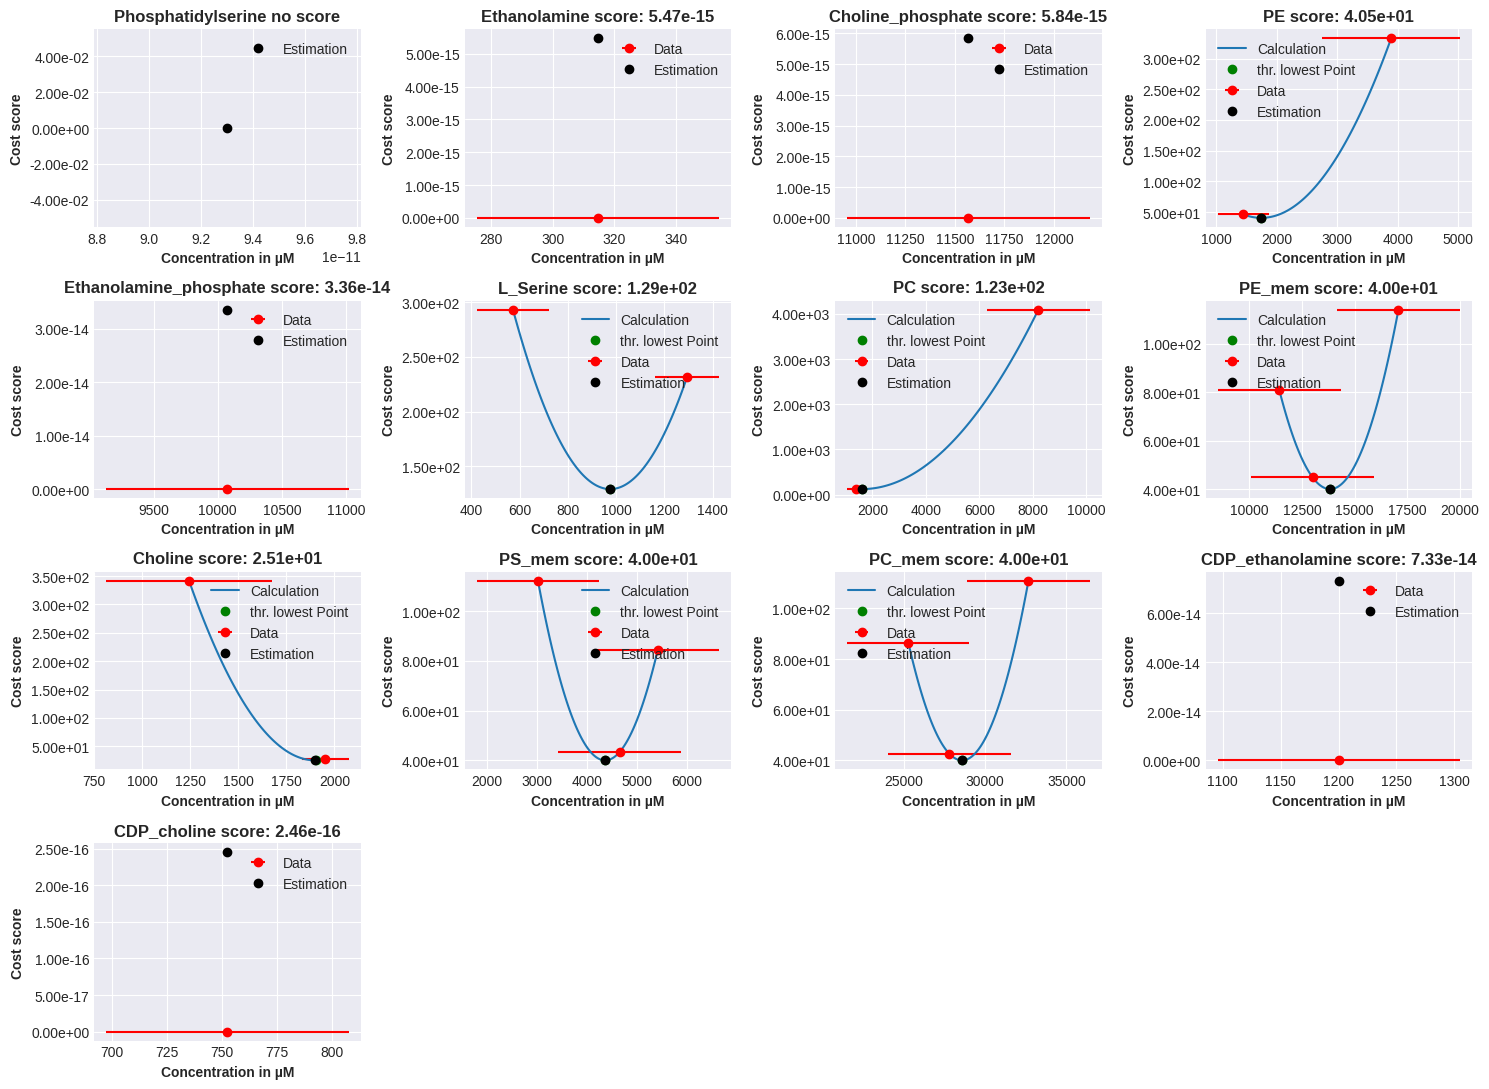

In [53]:
scores = list(map(float, df.columns.to_list()))
for esti in sorted(scores)[:1]:
    
    model.resetToOrigin()
    parameters = df[str(esti)].to_dict()
    model = set_model_parameters(model, parameters)
    try:
        model.steadyState()
    except RuntimeError:
        print(esti)
        continue
    
    res = model.simulate()
    
    simu_p = simulation_to_panda(model, res[-1::])
    simu_d = simu_p[-1::].to_dict('list')
    species = simu_p.columns.tolist()[1:]
    print(len(species))
    rowlength = len(species)/3    
    fig, axs = plt.subplots(figsize=(15,11), 
                        nrows=int(rowlength), ncols=4     # fix as above
                        ) 
    
    for ax in axs.flatten():
        ax.set_axis_off()
        
    targets = zip(species, axs.flatten())
    the_score = 0
    for (mole, ax) in targets:
        # plot species that have test data
        if mole in scatter_dic:
            # produce array of lenght= 100 in the boundaries of species lowest and hightest value
            ar = np.linspace(min(scatter_dic[mole]['values'][0]), max(scatter_dic[mole]['values'][0]), num=100)
            if ar[0]/ar[-1]!=1:
                ar_scores = calc_scores(ar, mole, scatter_dic)
                # plot graph as line
                ax.plot(ar, ar_scores, label='Calculation')
                # find index of element with lowest score
                minElement = np.argmin(ar_scores)
                the_score += np.min(ar_scores)
                # plot dot of lowest possible value
                ax.errorbar(x=ar[minElement], y=ar_scores[minElement],
                             fmt='o', color='green', label='thr. lowest Point')
                
            scatter_amount = np.asarray(scatter_dic[mole]['values']) 
            scatter_std = np.asarray(scatter_dic[mole]['std'])
            scatter_scores = calc_scores(scatter_amount[0], mole, scatter_dic)

            ax.errorbar(x=scatter_amount[0], y=scatter_scores,
                                 xerr=scatter_std[0], fmt='o', color='red', label='Data')
            
            ax.errorbar(x=simu_d[mole], y=calc_scores(simu_d[mole], mole, scatter_dic),
                                 fmt='o', color='black', label='Estimation')
            num = calc_scores(simu_d[mole], mole, scatter_dic)
            try :
                ax.set_title(translation_dic[mole] + f' score: {float(num):.2e}', fontweight="bold")
            except: 
                ax.set_title(mole + f' score: {float(num):.2e}', fontweight="bold")
        # plot species that are not restrained
        else: 
            ax.errorbar(x=simu_d[mole], y=0,
                                 fmt='o', color='black', label='Estimation')
            ax.set_title(mole + f' no score', fontweight="bold")
        
        # formatting axes to look decent
        ax.set_xlabel('Concentration in µM', fontweight="bold")
        ax.set_ylabel('Cost score', fontweight="bold")
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
        #ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))       

        ax.legend()
        ax.set_axis_on()
    print((1-esti/the_score)*100)
    plt.tight_layout()
    plt.savefig('MM_cost_score.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Parameter Uncertainty Investigation looking at the three major Phospholipids

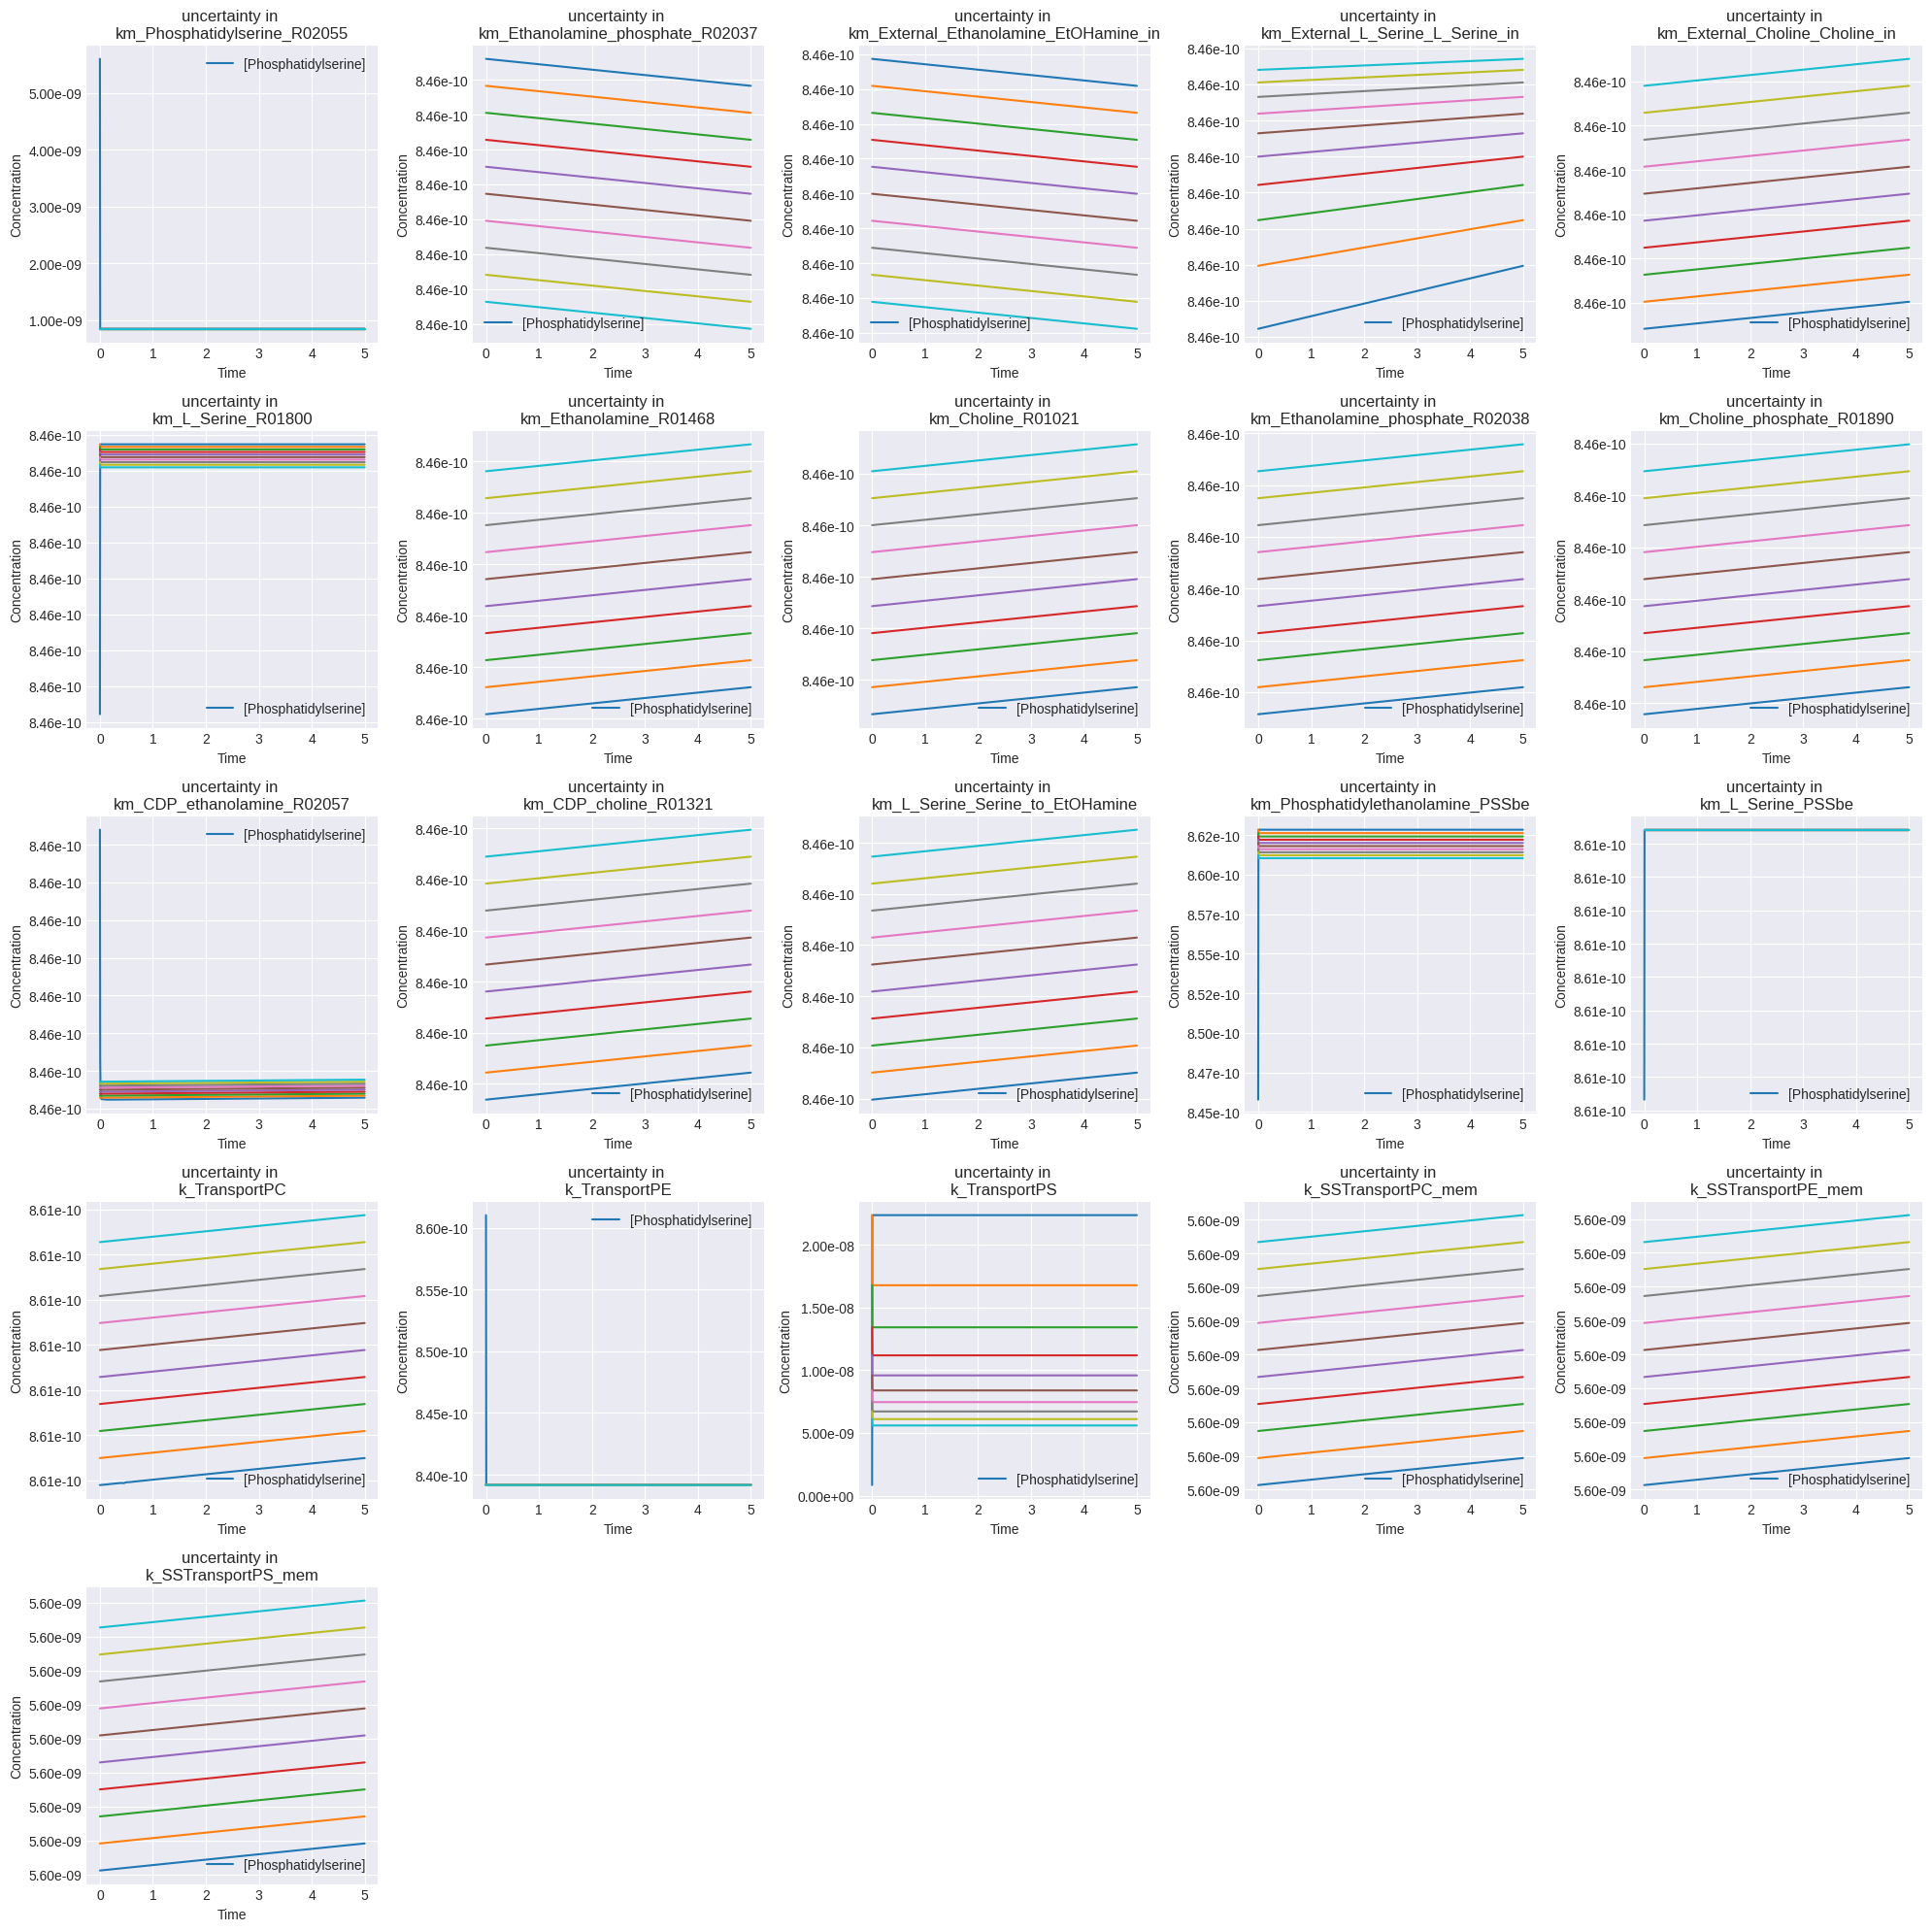

In [34]:
model = set_model_parameters(model, best_para_models[name].to_dict())
r = model
def plot_param_uncertainty(model, startVal, name, num_sims, col=1):
    stdDev = 0.6

    # assumes initial parameter estimate as mean and iterates 60% above and below.
    vals = np.linspace((1-stdDev)*startVal, (1+stdDev)*startVal, num_sims)
    for val in vals:
        r = model
        exec("r.%s = %f" % (name, val))
        result = r.simulate(0, 5,1000)
        #print(result.colnames)
        plt.plot(result[:,0],result[:,col])
        plt.title("uncertainty in \n" + name)
        
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2e'))
    
    plt.legend([result.colnames[col]])
    plt.xlabel("Time")
    plt.ylabel("Concentration")

startVals = r.getGlobalParameterValues();
names = list(enumerate([x for x in r.getGlobalParameterIds() if ("K" in x or "k" in x)]));

n = len(names) + 1;
dim = int(np.ceil(np.sqrt(n)))
fig = plt.figure(figsize=(20,20))
for i, next_param in enumerate(names):
    plt.subplot(dim,dim,i+1)
    plot_param_uncertainty(model, startVals[next_param[0]], next_param[1], 10)
    
plt.tight_layout()
plt.show()

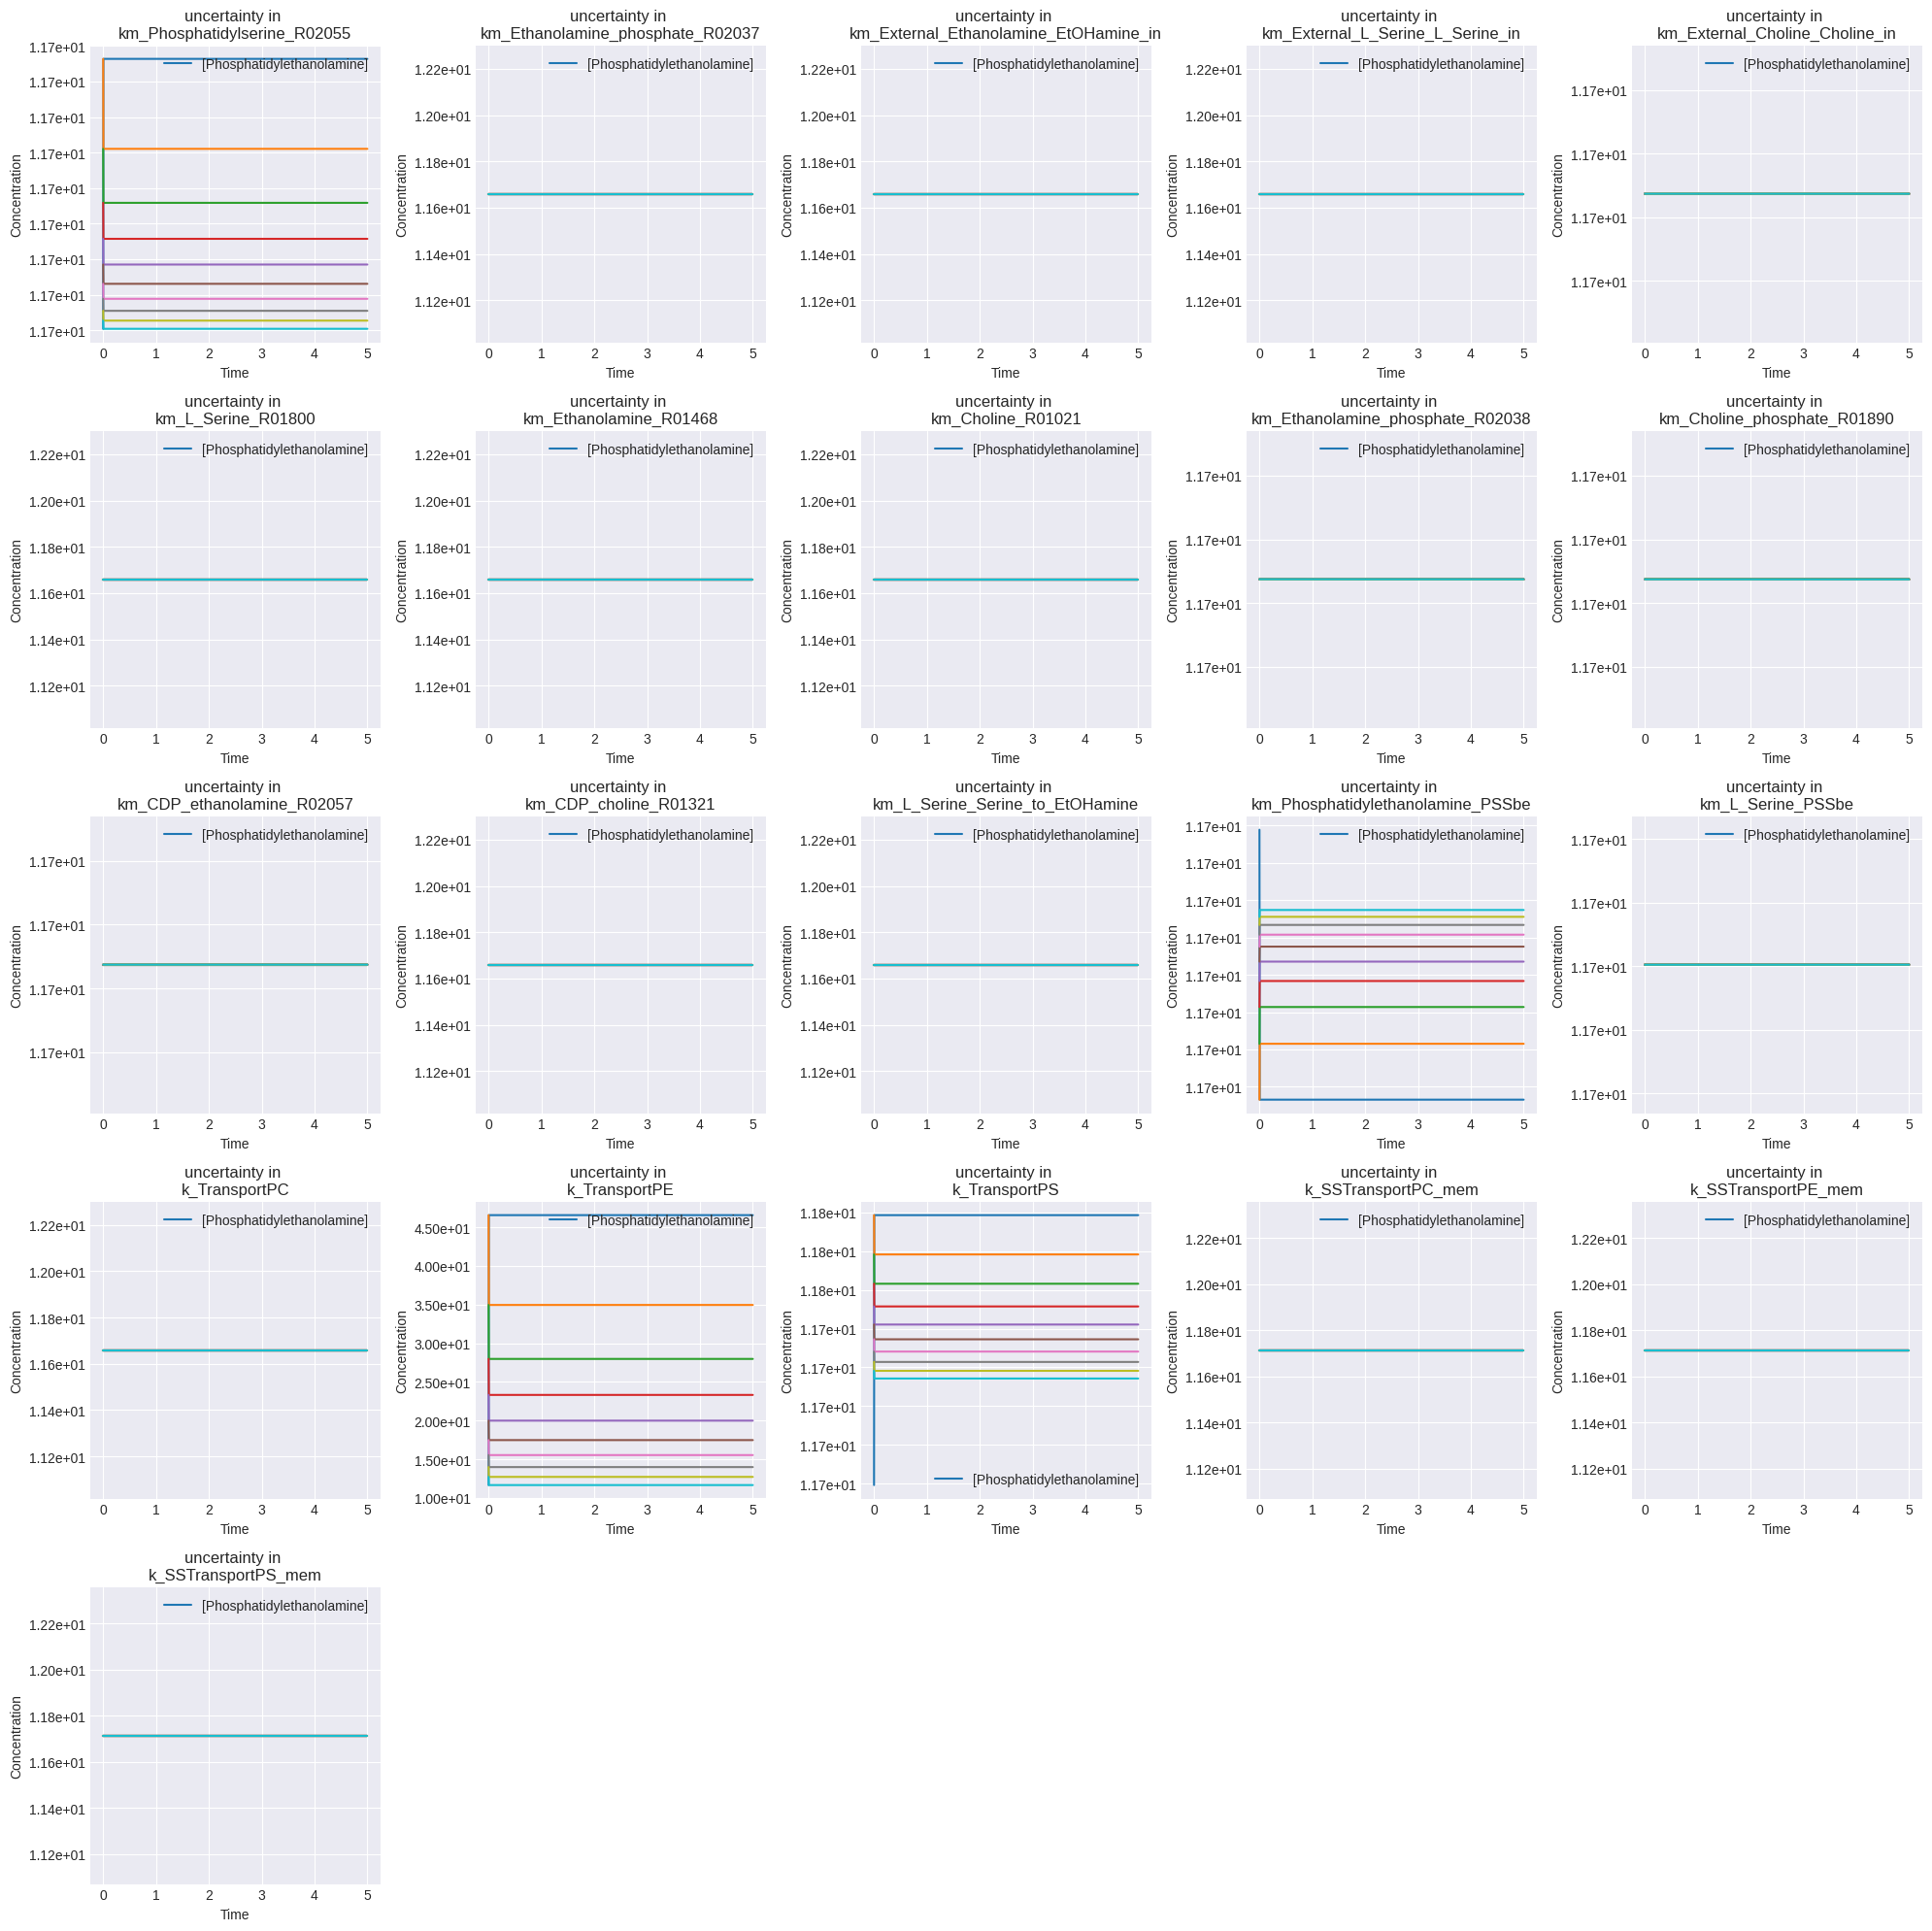

In [35]:
startVals = r.getGlobalParameterValues();
names = list(enumerate([x for x in r.getGlobalParameterIds() if ("K" in x or "k" in x)]));

n = len(names) + 1;
dim = int(np.ceil(np.sqrt(n)))
fig = plt.figure(figsize=(20,20))
for i, next_param in enumerate(names):
    plt.subplot(dim,dim,i+1)
    plot_param_uncertainty(model, startVals[next_param[0]], next_param[1], 10, col=4)
    
plt.tight_layout()
plt.show()

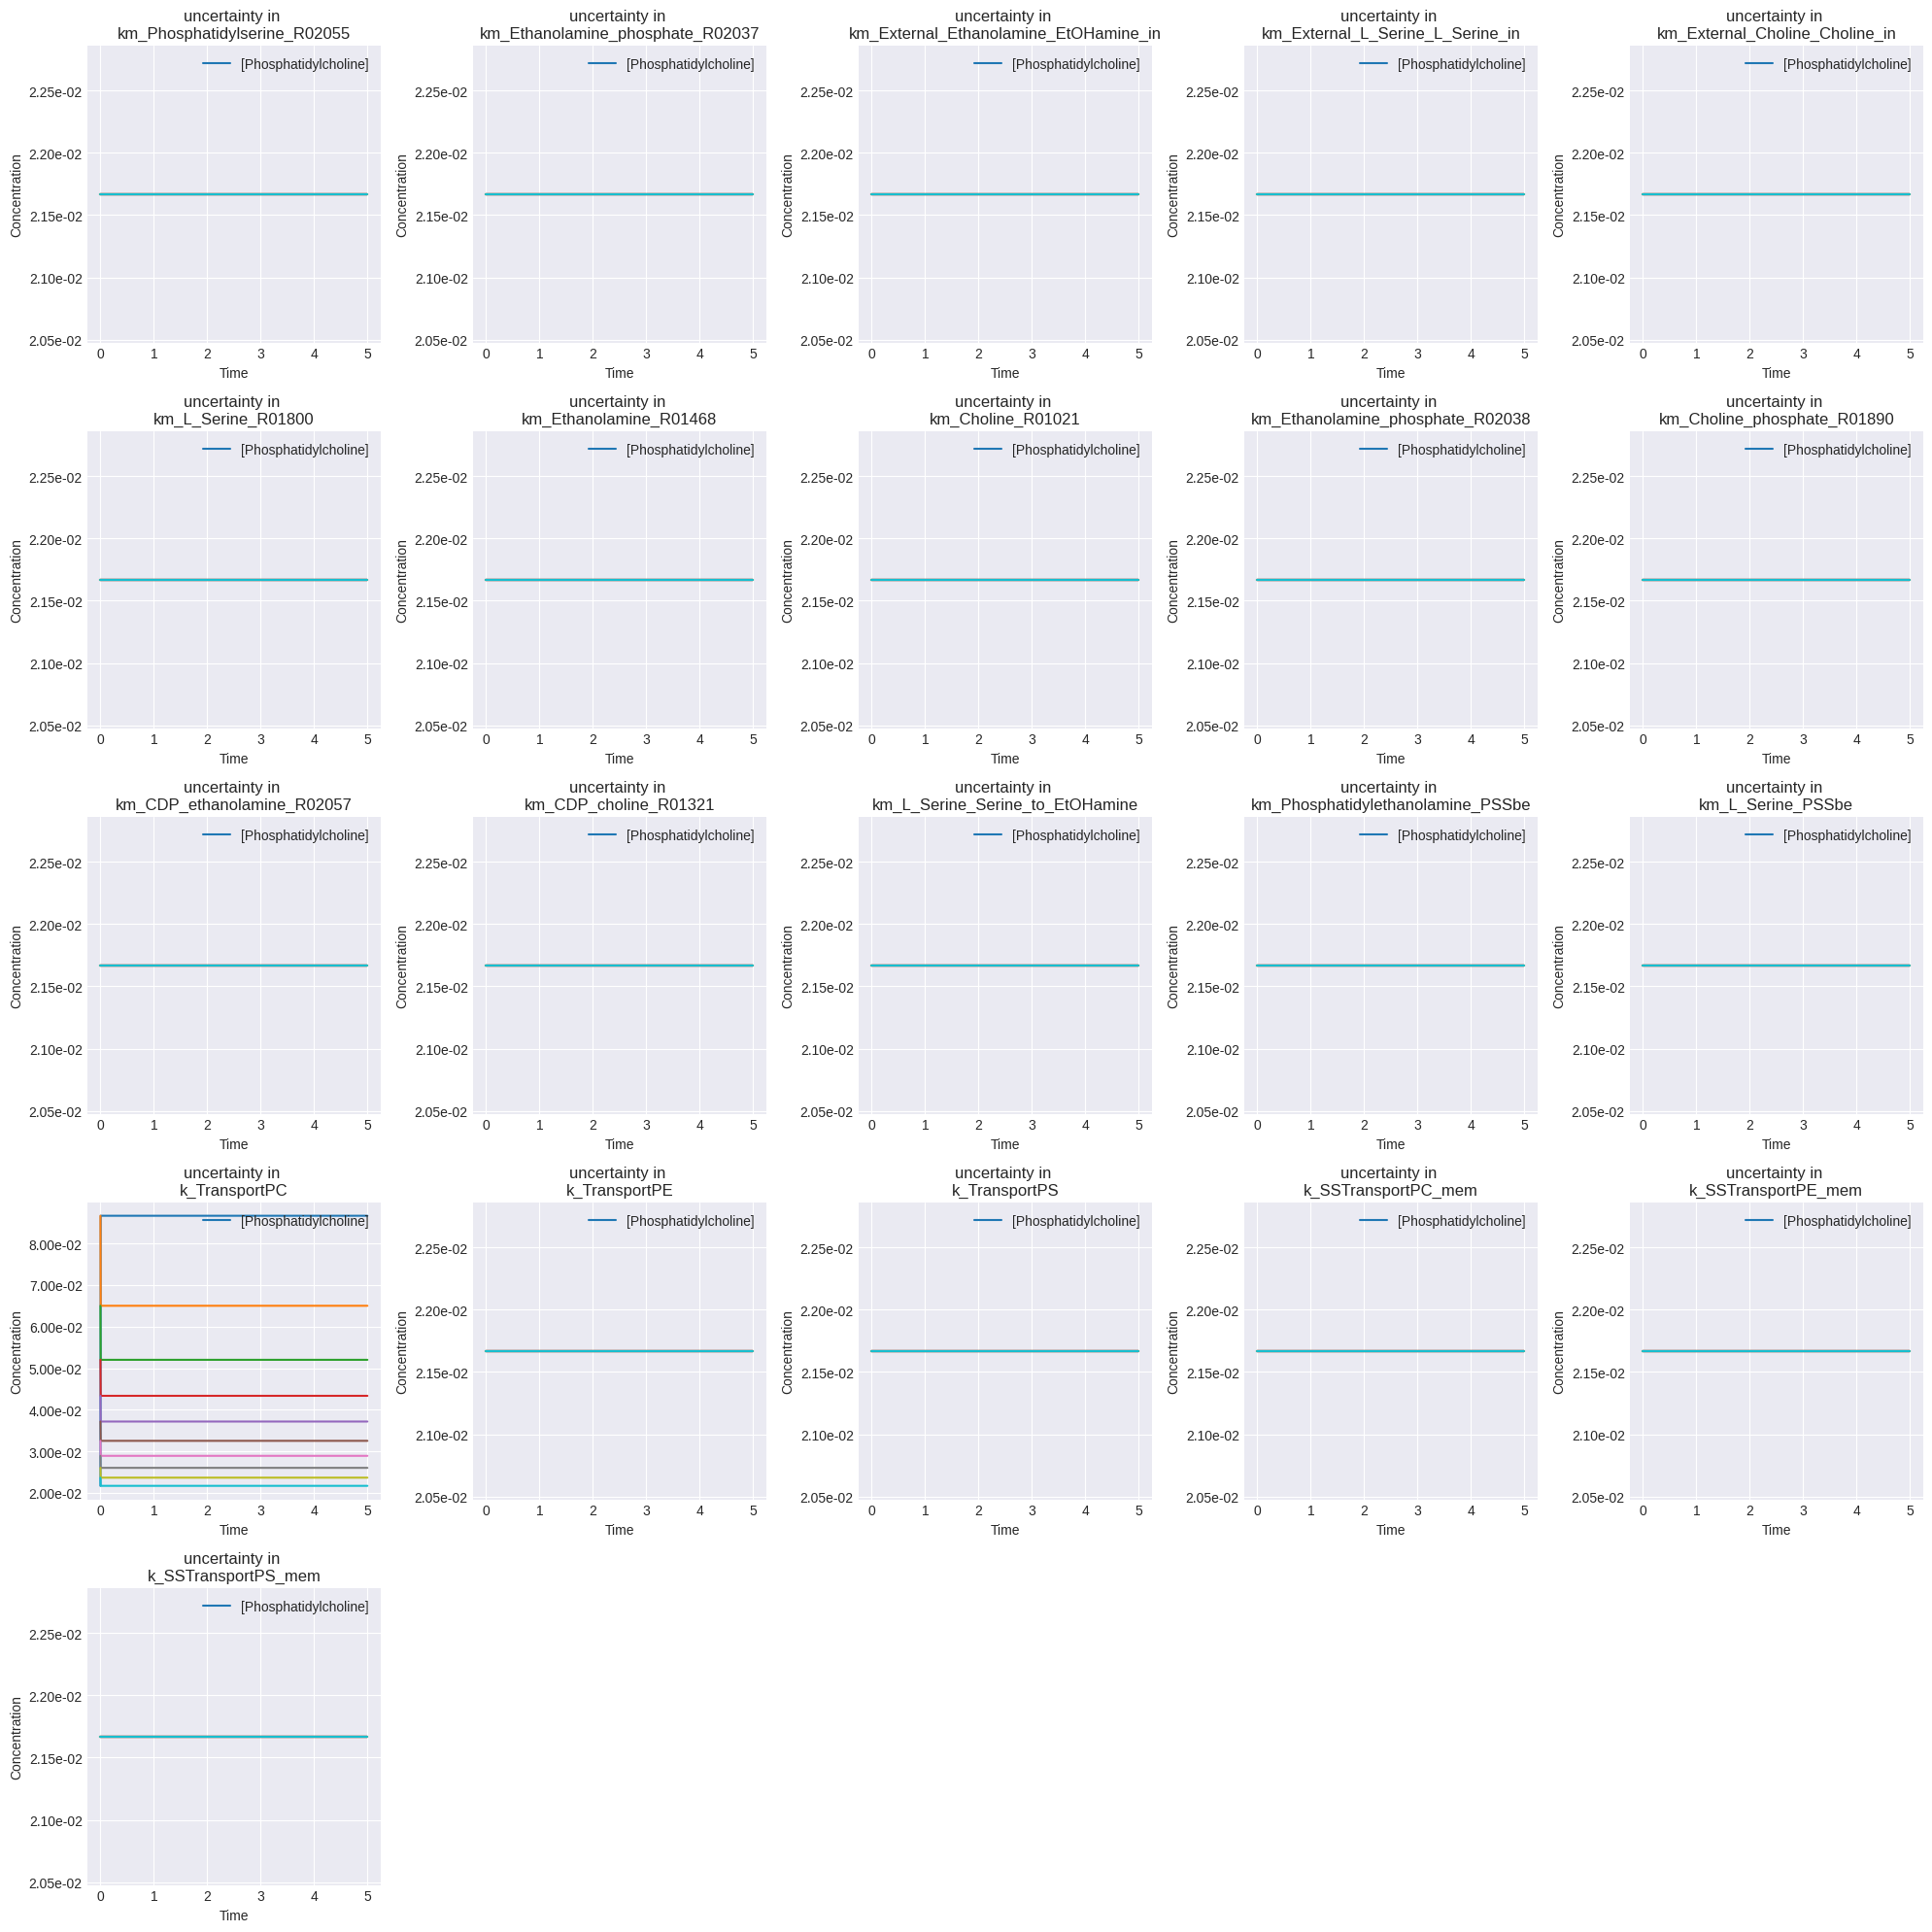

In [39]:
startVals = r.getGlobalParameterValues();
names = list(enumerate([x for x in r.getGlobalParameterIds() if ("K" in x or "k" in x)]));

n = len(names) + 1;
dim = int(np.ceil(np.sqrt(n)))
fig = plt.figure(figsize=(20,20))
for i, next_param in enumerate(names):
    plt.subplot(dim,dim,i+1)
    plot_param_uncertainty(model, startVals[next_param[0]], next_param[1], 10, col=7)
    
plt.tight_layout()
plt.show()

In [157]:
#model.resetToOrigin()
#model = set_model_parameters(model, df[str(esti)].to_dict())
#model.simulate(0,5, 100)
res = model.simulate()
    
simu_p = simulation_to_panda(model, res[-1::])

In [54]:
import seaborn as sns

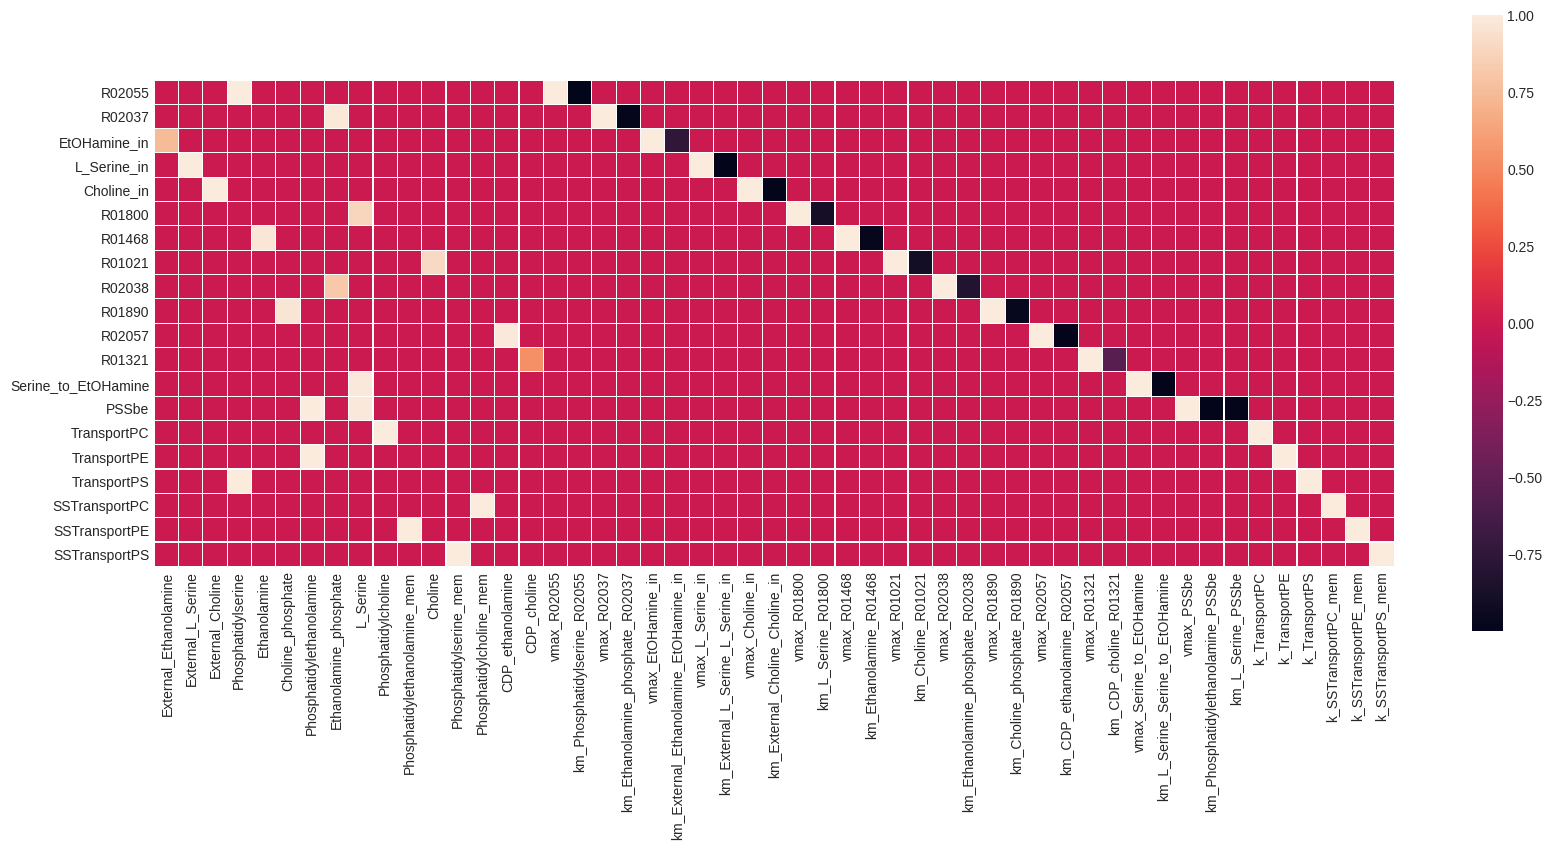

In [55]:
model = set_model_parameters(model, best_para_models[name].to_dict())
rr = model
# Elasticity Coefficients
modifier = rr.bs()+rr.fs()+rr.ps()
modifier = modifier[:-1]
data = []
for species in modifier:
    if species == 't':
        continue
    values = []
    for reaction in rr.rs():
        values.append(rr.getEE(reaction, species))
    data.append(values)
    
df_ec = pd.DataFrame(data, columns=rr.rs(), index=modifier)

fig = plt.figure(figsize=(20,8))
plot = sns.heatmap(df_ec.T, linewidths=.1, square=True)
_ = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
bottom, top = plot.get_ylim()
#_ = plot.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

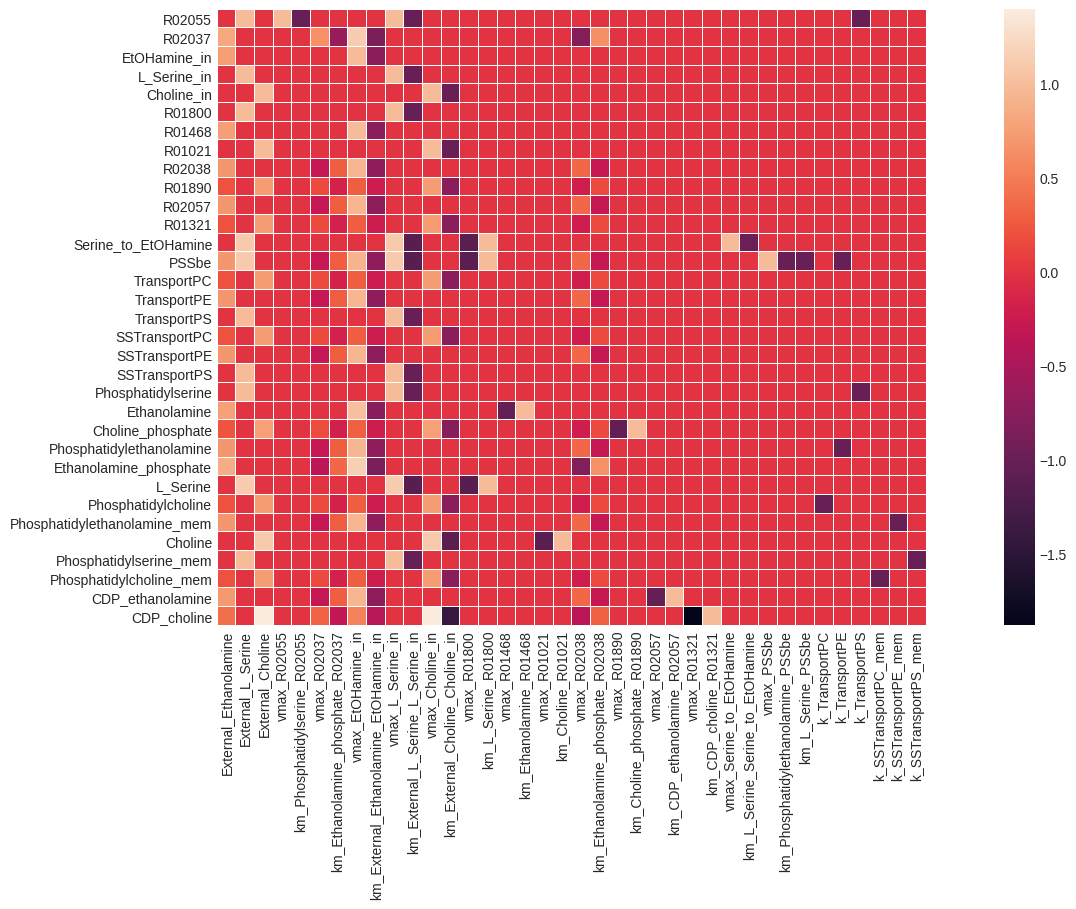

In [56]:
# Controll Coefficents 
model = set_model_parameters(model, best_para_models[name].to_dict())
rr = model
modifier = rr.bs()+rr.ps()
data = []
for species in modifier[:-1]:
    if species == 't':
        continue
    #print(species)
    values = []
    for reaction in rr.rs()+ rr.fs():
        #print(reaction)
        values.append(rr.getCC(reaction, species))
    data.append(values)
    
df_cc = pd.DataFrame(data, columns=rr.rs() + rr.fs(), index=modifier[:-1])
fig = plt.figure(figsize=(20,8))
plot = sns.heatmap(df_cc.T, linewidths=.1, square=True)
_ = plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
bottom, top = plot.get_ylim()
#_ = plot.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

Minimum element from Numpy Array :  40.00000189858561


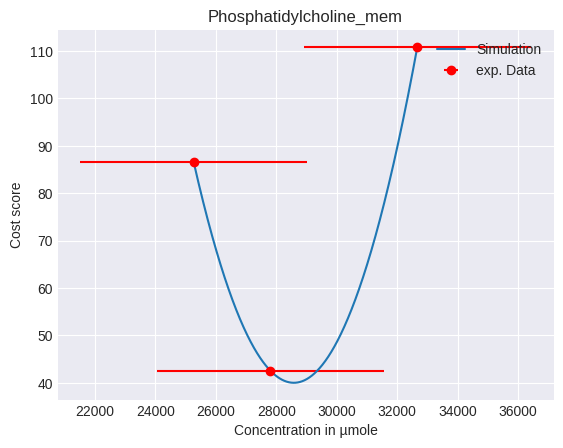

Minimum element from Numpy Array :  40.00000114248587


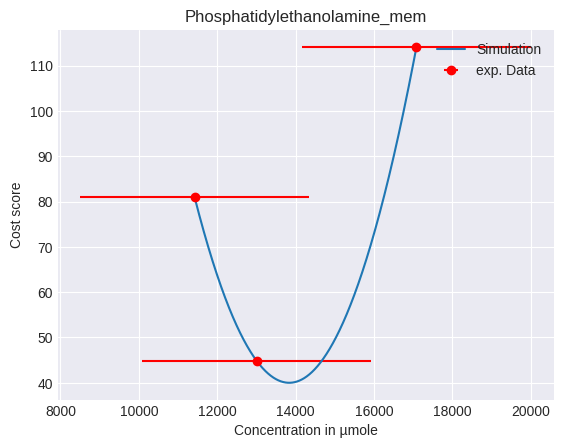

Minimum element from Numpy Array :  40.000020874571334


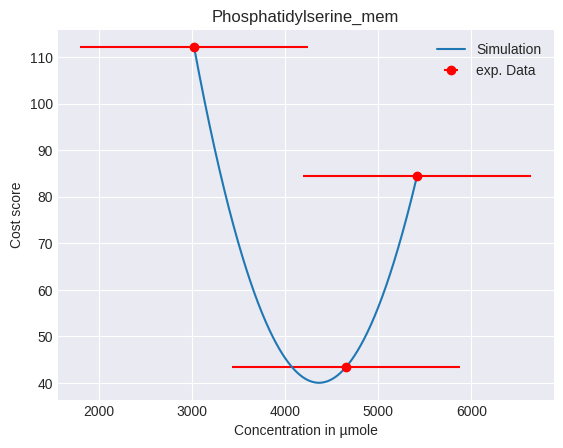

Minimum element from Numpy Array :  0.0


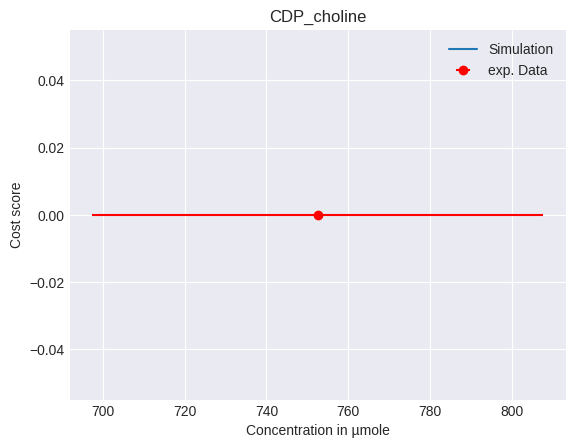

Minimum element from Numpy Array :  0.0


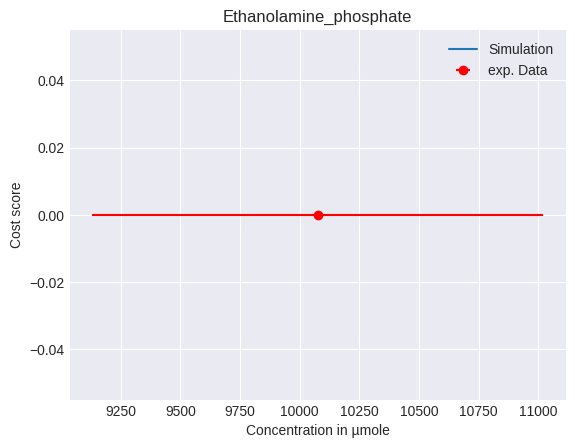

Minimum element from Numpy Array :  0.0


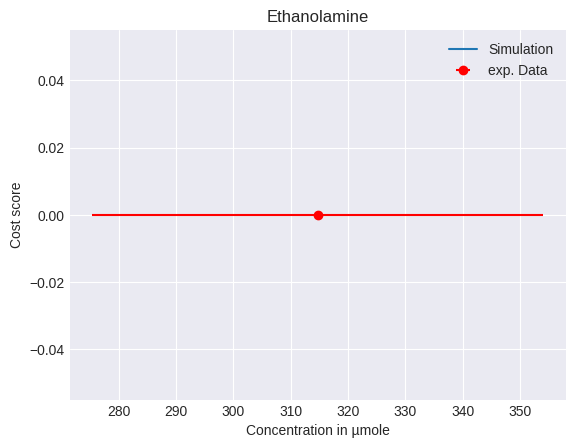

Minimum element from Numpy Array :  0.0


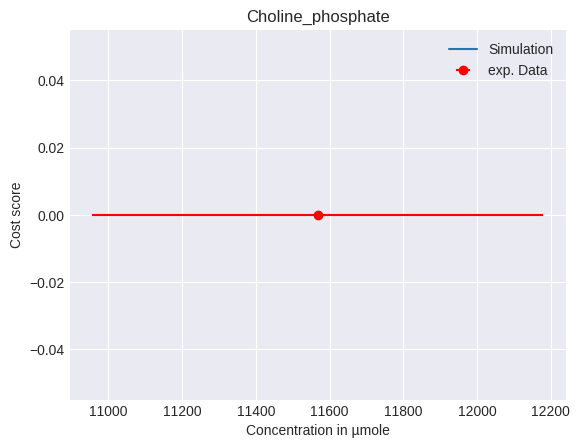

Minimum element from Numpy Array :  0.0


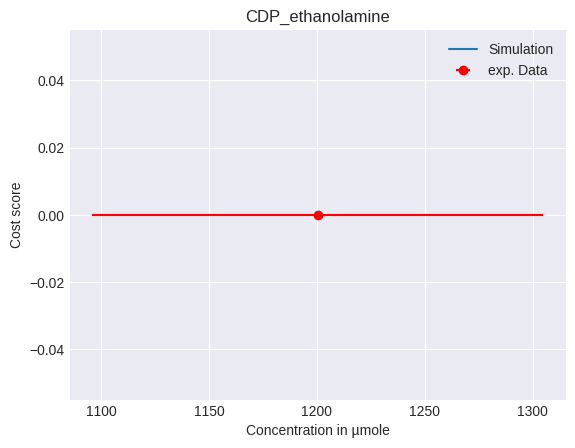

Minimum element from Numpy Array :  129.31466967187615


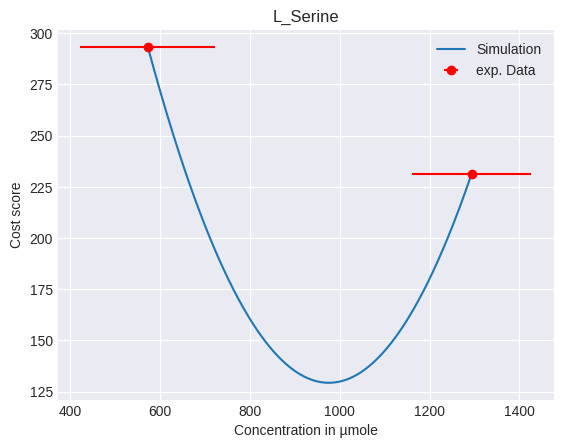

Minimum element from Numpy Array :  25.07557139038882


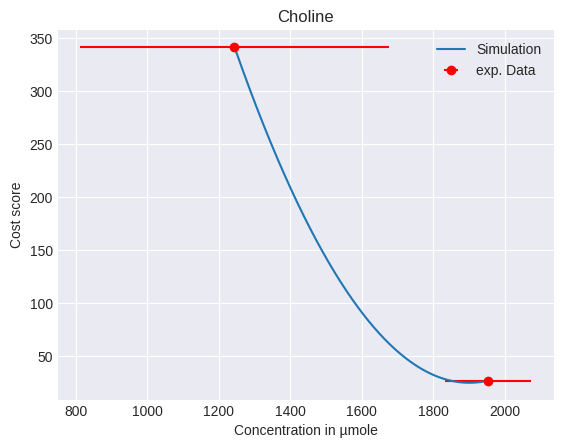

Minimum element from Numpy Array :  123.3872218600666


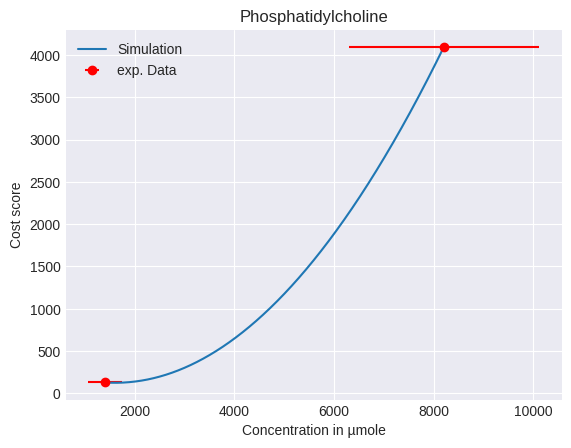

Minimum element from Numpy Array :  40.50959161591757


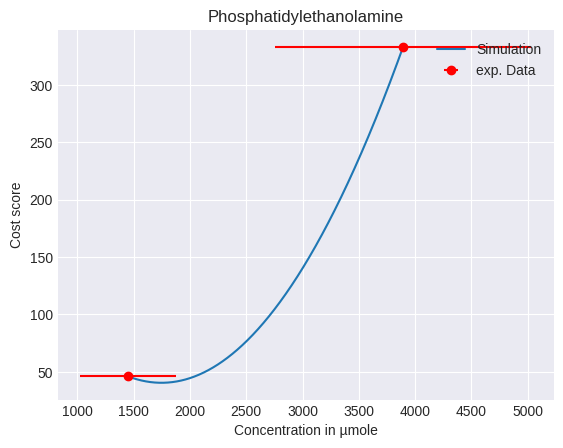

NameError: name 'minArray' is not defined

In [24]:
#minArray = np.zeros(len(scatter_dic))
for it, mole in enumerate(scatter_dic):
        scatter_amount = np.asarray(scatter_dic[mole]['values']) 
        scatter_std = np.asarray(scatter_dic[mole]['std'])
        scatter_scores = calc_scores(scatter_amount[0], mole, scatter_dic)
        
        plt.errorbar(x=scatter_amount[0], y=scatter_scores,
                             xerr=scatter_std[0], fmt='o', color='red')
        
        ar = np.linspace(min(scatter_dic[mole]['values'][0]), max(scatter_dic[mole]['values'][0]), num=1000)
        ar_scores = calc_scores(ar, mole, scatter_dic)
        # Find Minimum
        minElement = np.amin(ar_scores)
        #minArray[it]= minElement
        print('Minimum element from Numpy Array : ', minElement)
        #result = np.argmin(ar_scores)
        #print(result)
        
        plt.plot(ar, ar_scores)

        plt.legend(['Simulation','exp. Data'])
        plt.xlabel('Concentration in µmole')
        plt.ylabel('Cost score')
        plt.title(mole)
        plt.show()
        
print(minArray)
print(minArray.sum())

In [39]:
scatter_dic

{'Phosphatidylcholine_mem': {'values': [[25268.41448189764,
    27801.87265917603,
    32662.92134831461]],
  'std': [[3757.8126725459665, 3757.8126725459665, 3757.8126725459665]]},
 'Phosphatidylethanolamine_mem': {'values': [[11422.72159800251,
    13002.247191011238,
    17082.771535580527]],
  'std': [[2920.666171768269, 2920.666171768269, 2920.666171768269]]},
 'Phosphatidylserine_mem': {'values': [[3022.2222222222213,
    5416.85393258427,
    4652.434456928839]],
  'std': [[1223.1237395306018, 1223.1237395306018, 1223.1237395306018]]},
 'CDP_choline': {'values': [[752.5289405544399]],
  'std': [[55.10253234142428]]},
 'Choline_phosphate': {'values': [[11567.80024323354]],
  'std': [[611.35202360745]]},
 'CDP_ethanolamine': {'values': [[1200.3147564215446]],
  'std': [[104.48335703565778]]},
 'Ethanolamine_phosphate': {'values': [[10075.180857009856]],
  'std': [[945.3256112749988]]},
 'Ethanolamine': {'values': [[314.69392059549307]],
  'std': [[39.305643837223634]]},
 'L_Serine